In [1]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation

In [2]:
# Get the current working directory
cwd = os.path.normpath(os.path.dirname(os.getcwd()))

def load_csv(file_path):
    """
    Function to load a CSV file into a pandas DataFrame.
    """
    full_path = os.path.join(cwd, file_path)
    return pd.read_csv(full_path, index_col=0)

def process_dataframe(df, scenario, metric='rmse'):
    """
    Function to process a DataFrame and return average metrics along with boxplot statistics for RMSE.
    """
    # Calculate average metrics for 'train_time' and 'avg_time_epoch'
    average_metrics = df.groupby('architecture').agg({
        'train_time': 'mean',
        'avg_time_epoch': 'mean'
    }).reset_index()

    # Calculate boxplot statistics for RMSE
    stats = df.groupby('architecture')[metric].describe(percentiles=[.25, .5, .75])
    stats = stats[['min', '25%', '50%', '75%', 'max']]

    # Merge the average metrics with RMSE stats
    combined_metrics = pd.merge(average_metrics, stats, on='architecture')

    # Add model_type column
    combined_metrics['model_type'] = scenario

    return combined_metrics

def process_dataframe_clusterwise(df, cluster_users, scenario, cluster_id, metric='rmse'):
    """
    Function to process a DataFrame for a specific cluster and return average metrics along with boxplot statistics for RMSE.
    """
    # Filter DataFrame for users in the cluster
    df_cluster = df[df['user'].isin(cluster_users)]

    # Calculate average metrics for 'train_time' and 'avg_time_epoch'
    average_metrics = df_cluster.groupby('architecture').agg({
        'train_time': 'mean',
        'avg_time_epoch': 'mean'
    }).reset_index()

    # Calculate boxplot statistics for RMSE
    stats = df_cluster.groupby('architecture')[metric].describe(percentiles=[.25, .5, .75])
    stats = stats[['min', '25%', '50%', '75%', 'max']]

    # Merge the average metrics with RMSE stats
    combined_metrics = pd.merge(average_metrics, stats, on='architecture')

    # Add model_type and cluster columns
    combined_metrics['model_type'] = scenario
    combined_metrics['cluster'] = cluster_id

    return combined_metrics

In [3]:
# Define file paths for each CSV file
file_paths = {
    'FL_Grossload': [
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Grossload': [
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_Prosumption': [
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Prosumption': [
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_PV': [
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_PV': [
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_Totalload': [
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Totalload': [
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ]
}


# 1. Cluster wise results

In [4]:
y = np.loadtxt(f'../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=',').astype(int)
num_clusters = 10
cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 7, 14, 18, 22, 23, 25, 29], dtype=int64),
 1: array([6], dtype=int64),
 2: array([ 3,  4,  9, 13, 15, 19, 20, 30], dtype=int64),
 3: array([1], dtype=int64),
 4: array([21], dtype=int64),
 5: array([ 2, 28], dtype=int64),
 6: array([ 5, 10, 11, 12, 24, 26, 27], dtype=int64),
 7: array([8], dtype=int64),
 8: array([17], dtype=int64),
 9: array([16], dtype=int64)}

In [5]:
# Load and process all DataFrames
all_results = []
for cluster_id, users in cluster_users.items():
    user_identifiers = ['user' + str(user_id) for user_id in users]  # Adjust based on your user naming scheme
    for category, paths in file_paths.items():
        for path in paths:
            df = load_csv(path)
            processed_df = process_dataframe_clusterwise(df, user_identifiers, category, cluster_id, metric='rmse')
            all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)
combined_average_metrics.head(5)

architecture  train_time  avg_time_epoch       min       25%  \
0       global_bilstm    6.311175        6.153505  0.101538  0.108271   
1          global_cnn    1.577113        1.475209  0.120082  0.133410   
2  global_transformer   18.430852       17.676254  0.119594  0.138940   
3  global_soft_bilstm    4.536250        4.386328  0.094032  0.104720   
4  global_topk_bilstm    4.868483        4.669335  0.097814  0.107904   

        50%       75%       max    model_type  cluster  
0  0.128837  0.142943  0.203467  FL_Grossload        0  
1  0.147750  0.199360  0.201882  FL_Grossload        0  
2  0.149510  0.187728  0.247292  FL_Grossload        0  
3  0.120570  0.128177  0.192984  FL_Grossload        0  
4  0.120574  0.128736  0.197991  FL_Grossload        0

In [6]:
def standardize_and_simplify_model_names(name):
    """
    Standardize and simplify model names.
    - Removes 'global_' prefix.
    - Removes '_moe' suffix.
    - Replaces 'bilstm' with 'lstm'.
    - Standardizes names with 'soft' or 'topk' at the beginning.
    """
    # Replace specific substrings
    name = name.replace('global_', '').replace('_moe', '').replace('bilstm', 'Lstm').replace('lstm', 'Lstm').replace('cnn', 'Cnn').replace('transformer', 'Transformer').replace('dense', 'Dense')

    # Standardize names for 'soft' and 'topk'
    name_parts = name.split('_')
    for prefix in ['soft', 'topk']:
        if prefix in name_parts:
            name_parts.remove(prefix)
            return f'{prefix.title()}_{"_".join(name_parts)}'
    return name

def get_plot_title(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']
    

model_types = ['FL_Grossload', 'LL_Grossload', 'FL_Prosumption', 'LL_Prosumption', 'FL_PV', 'LL_PV', 'FL_Totalload', 'LL_Totalload']
num_clusters = 10  # Assuming 10 clusters

C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


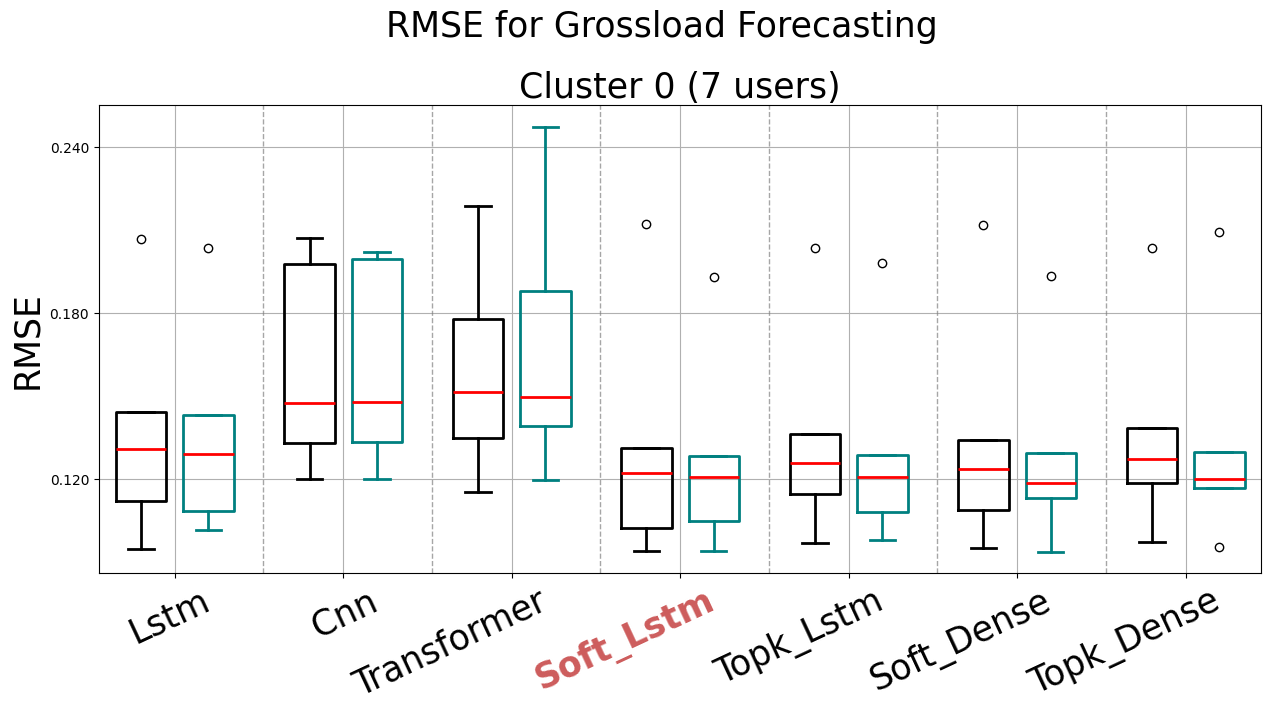

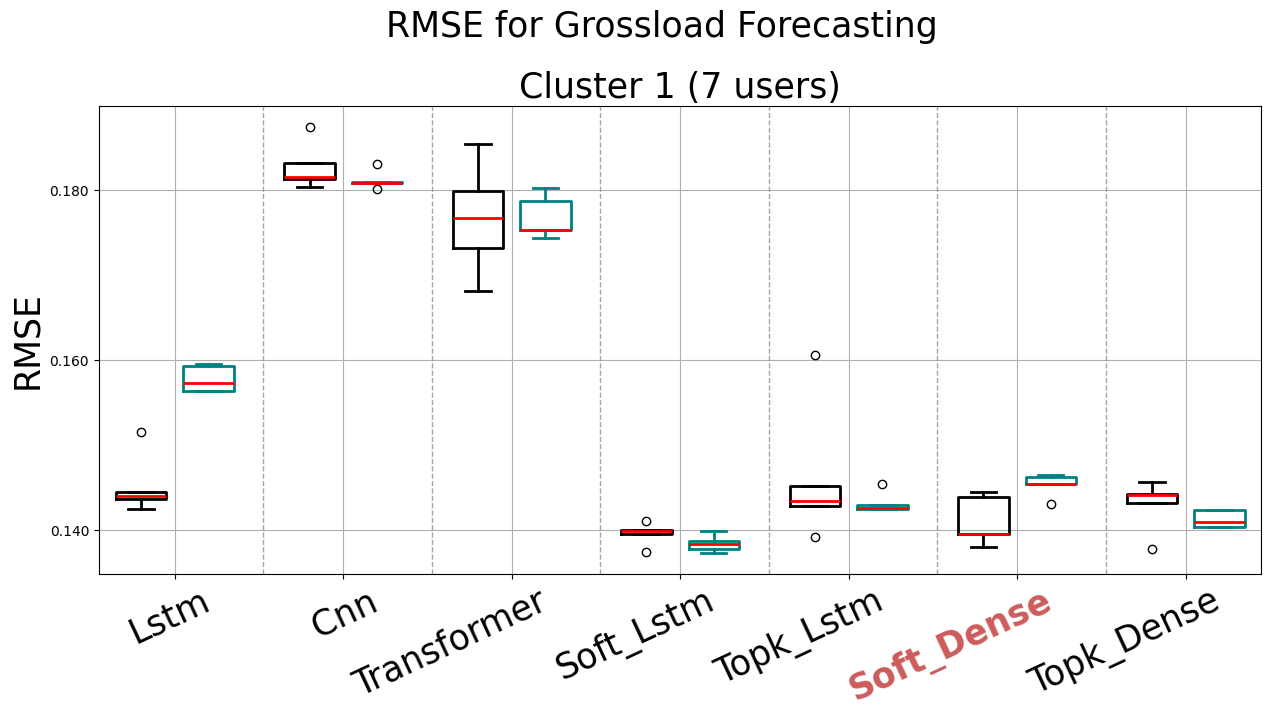

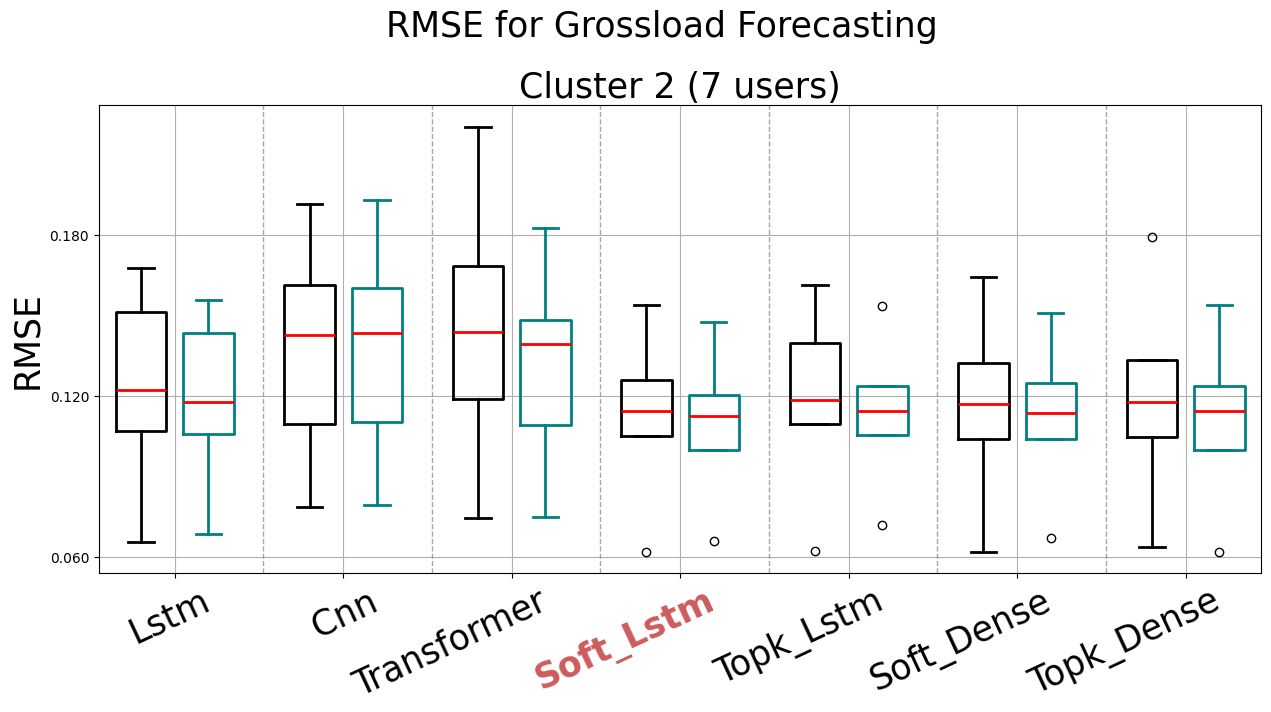

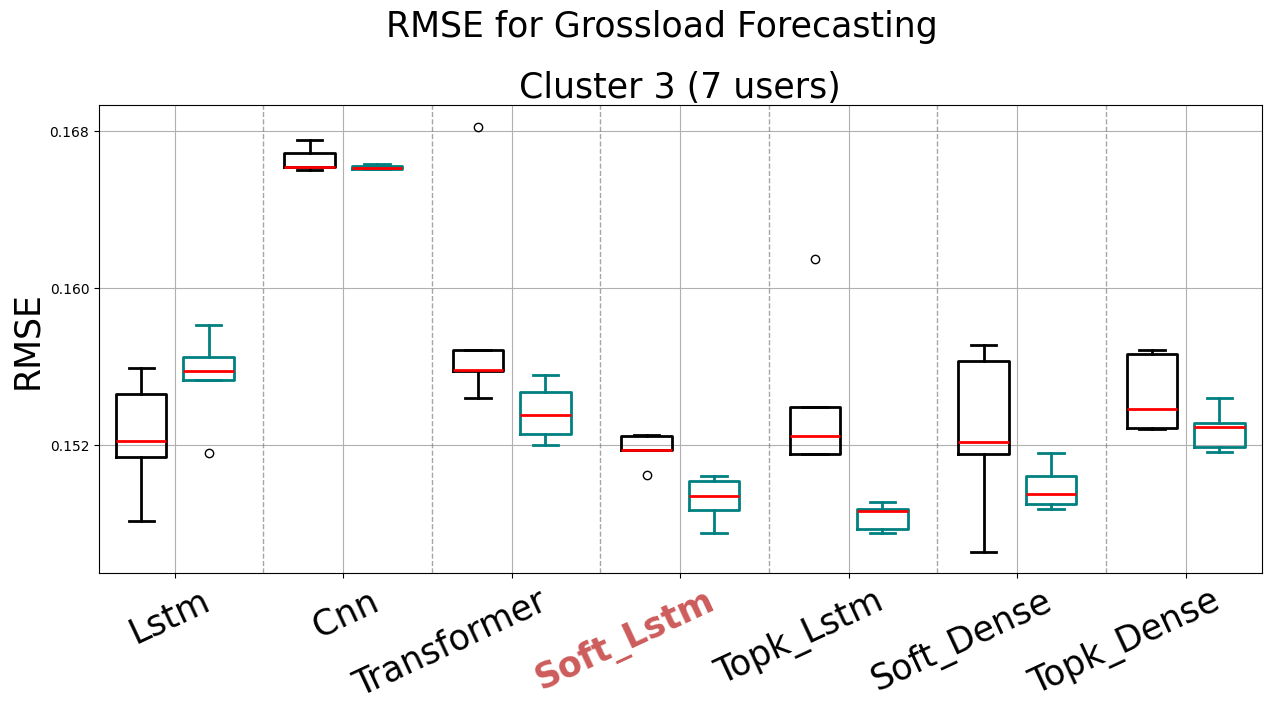

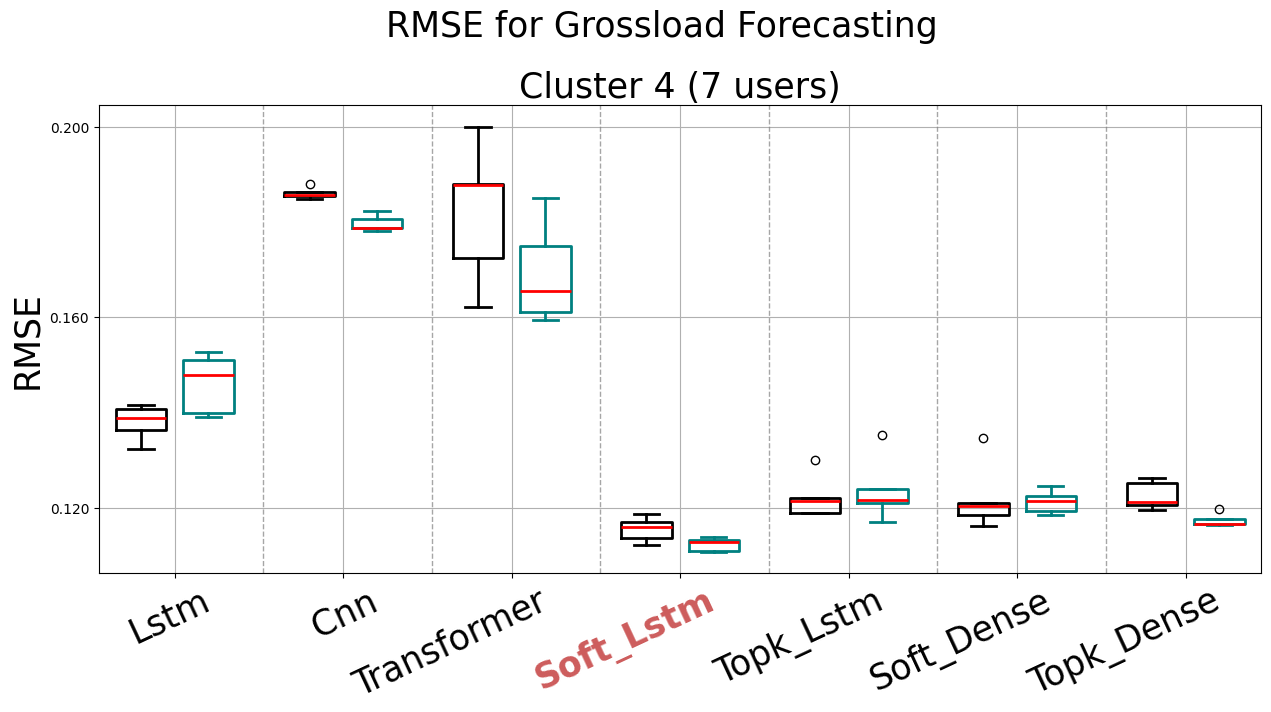

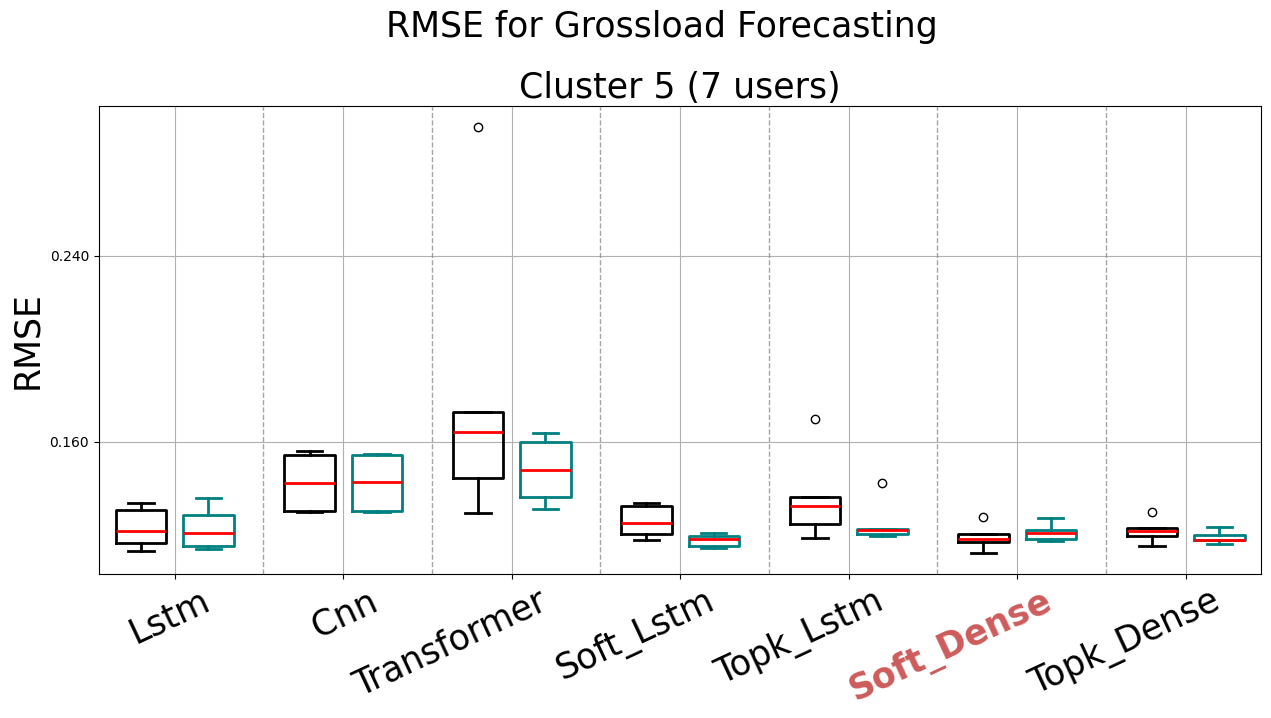

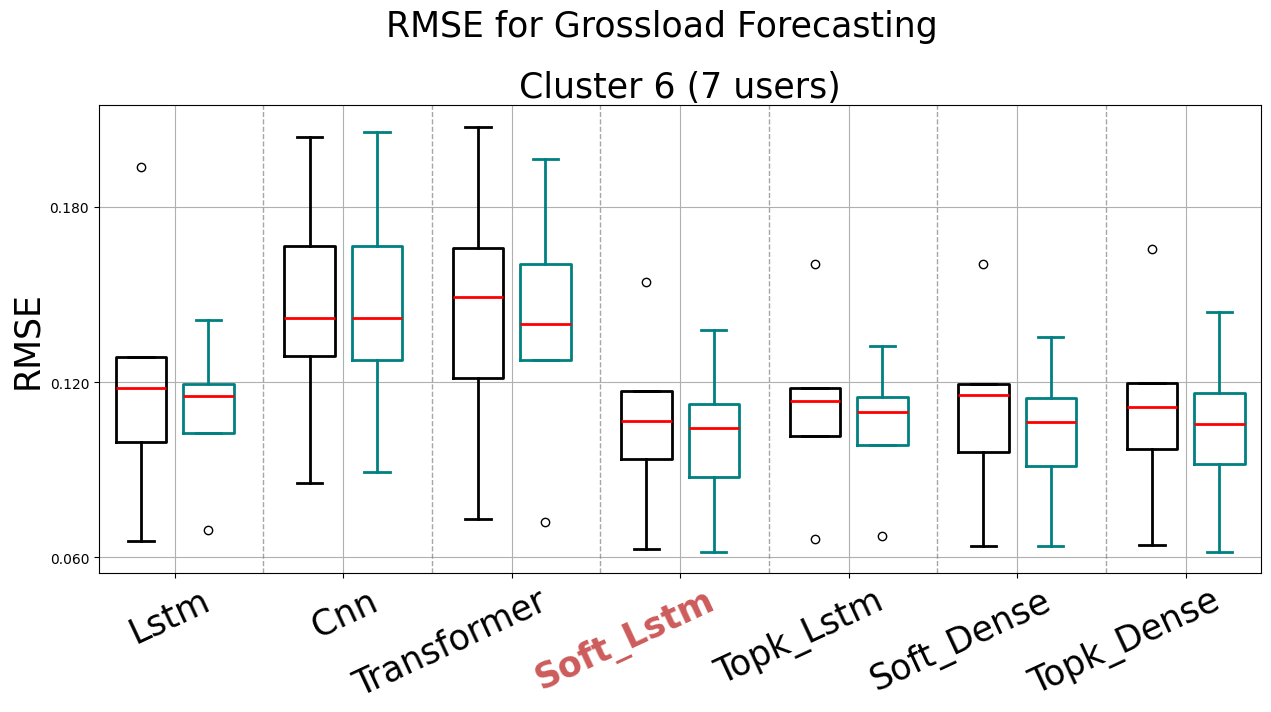

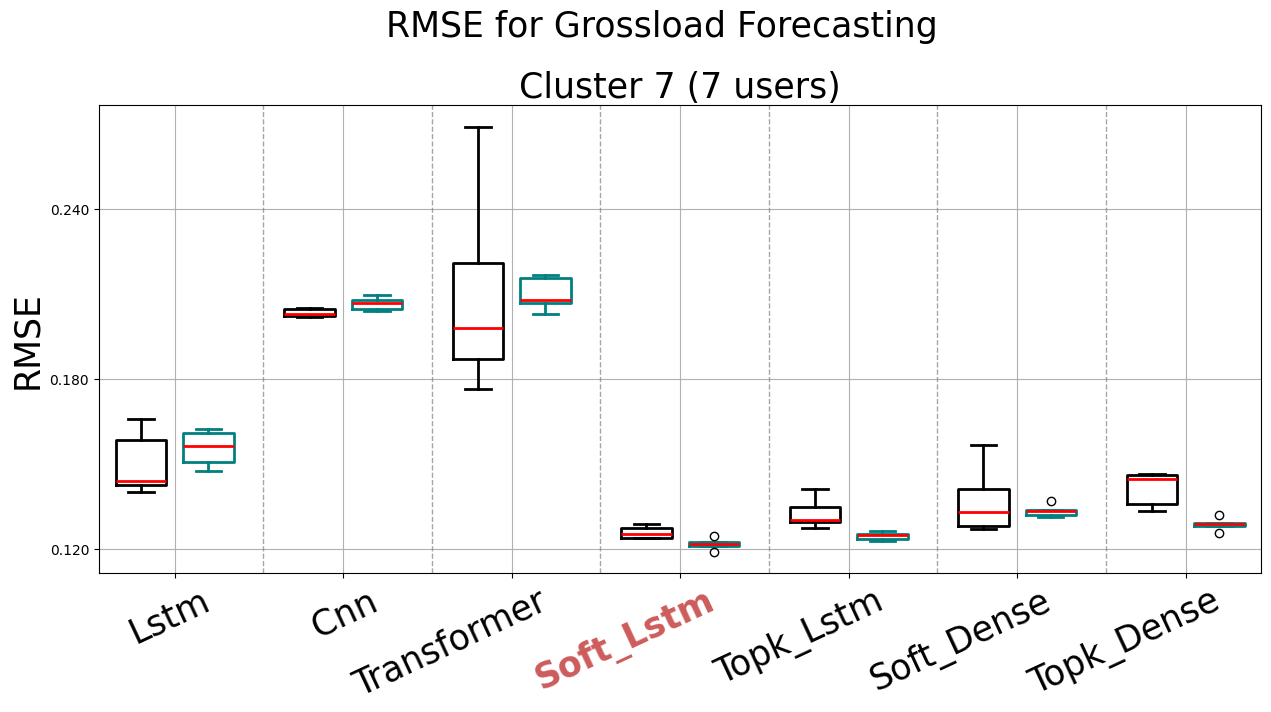

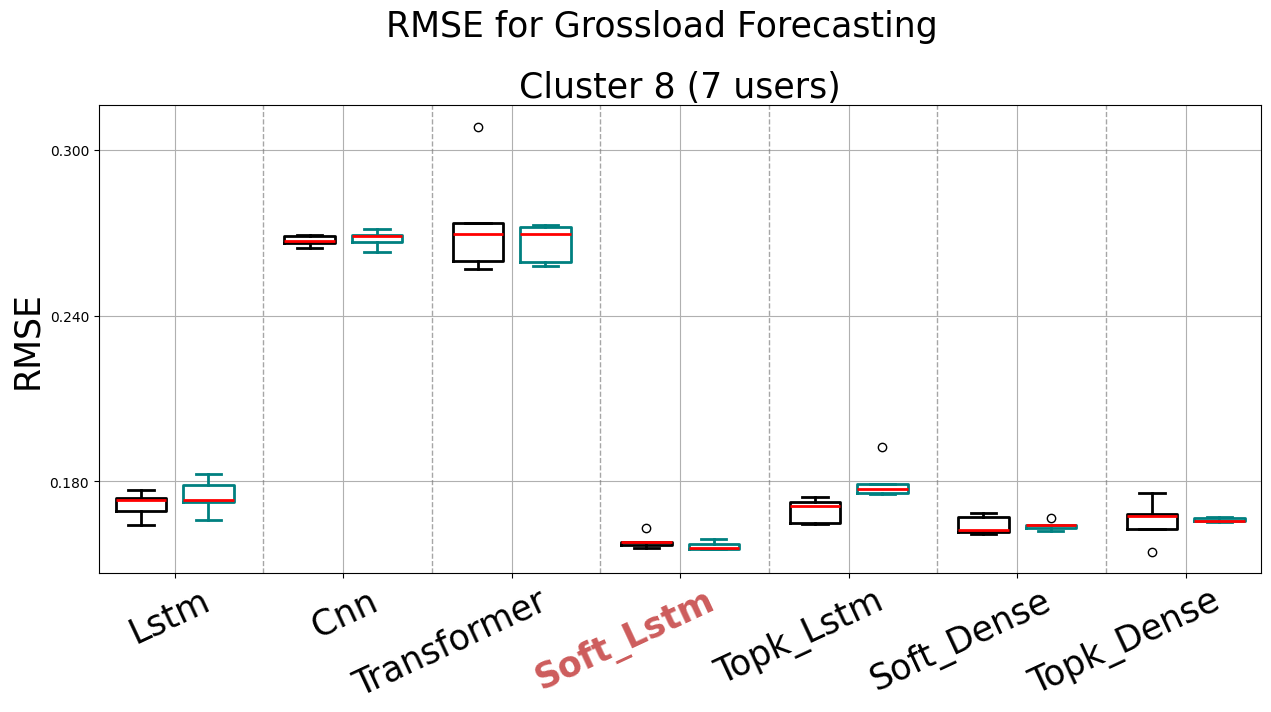

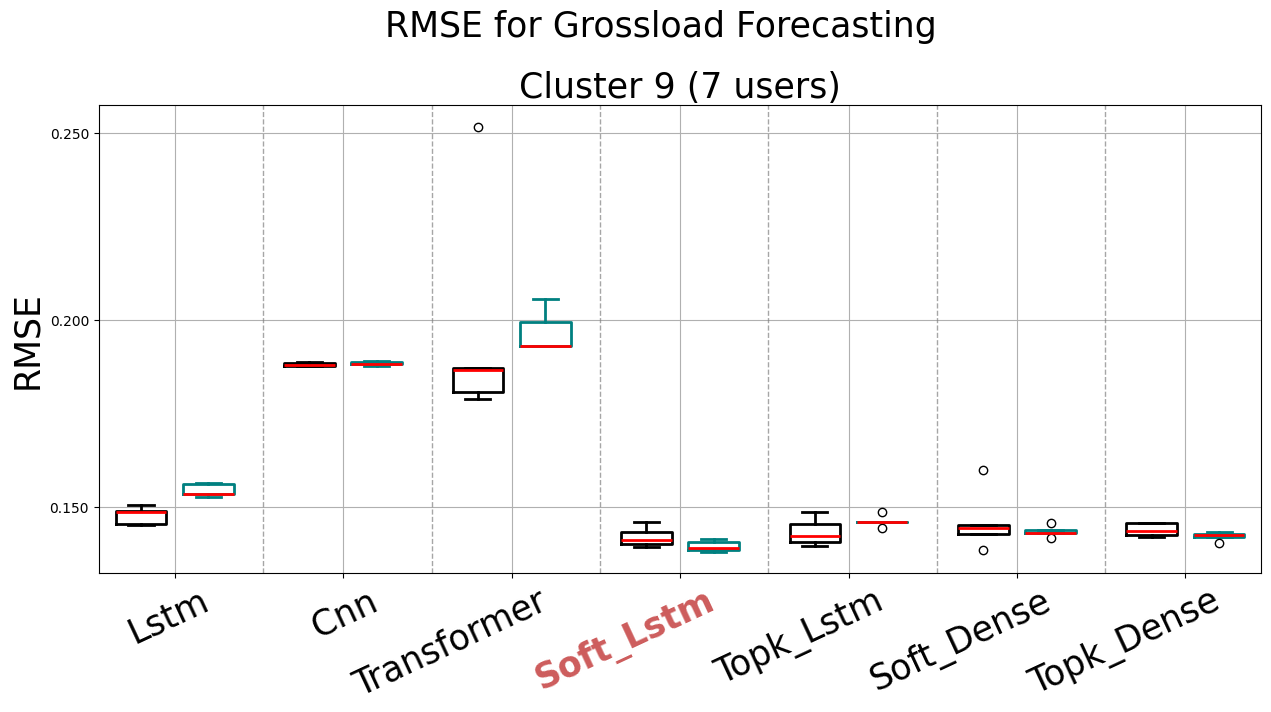

C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


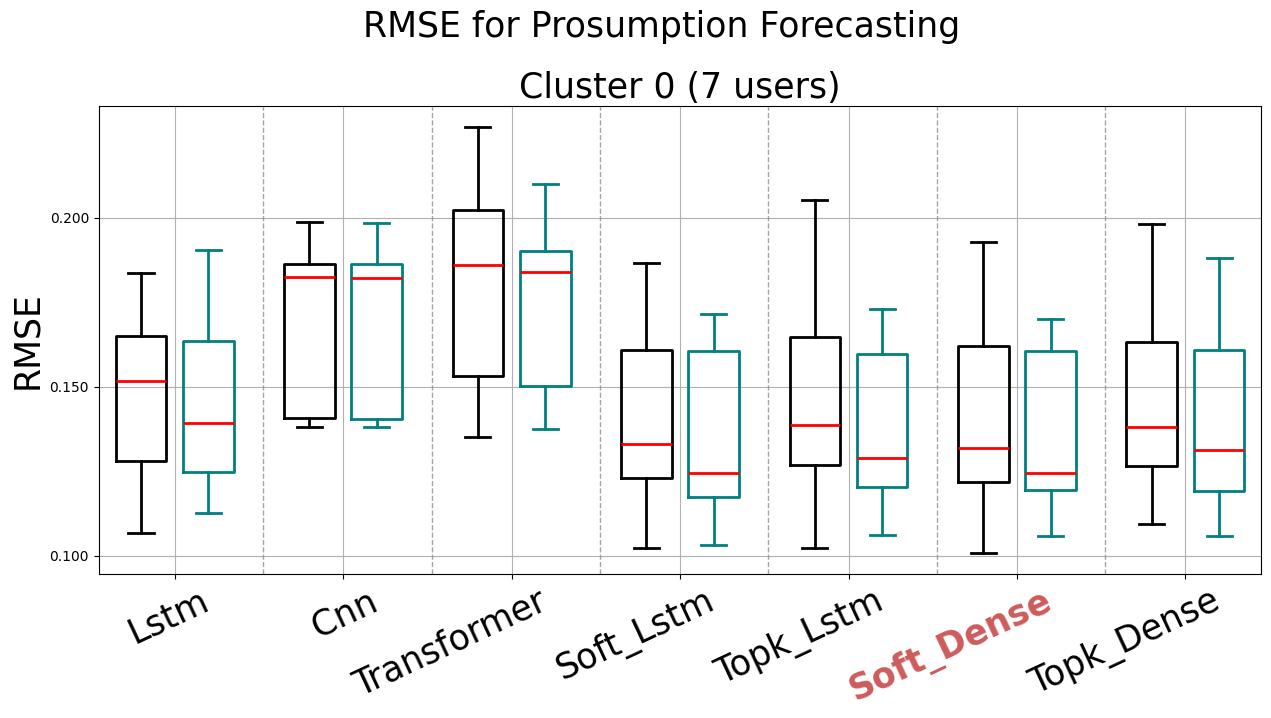

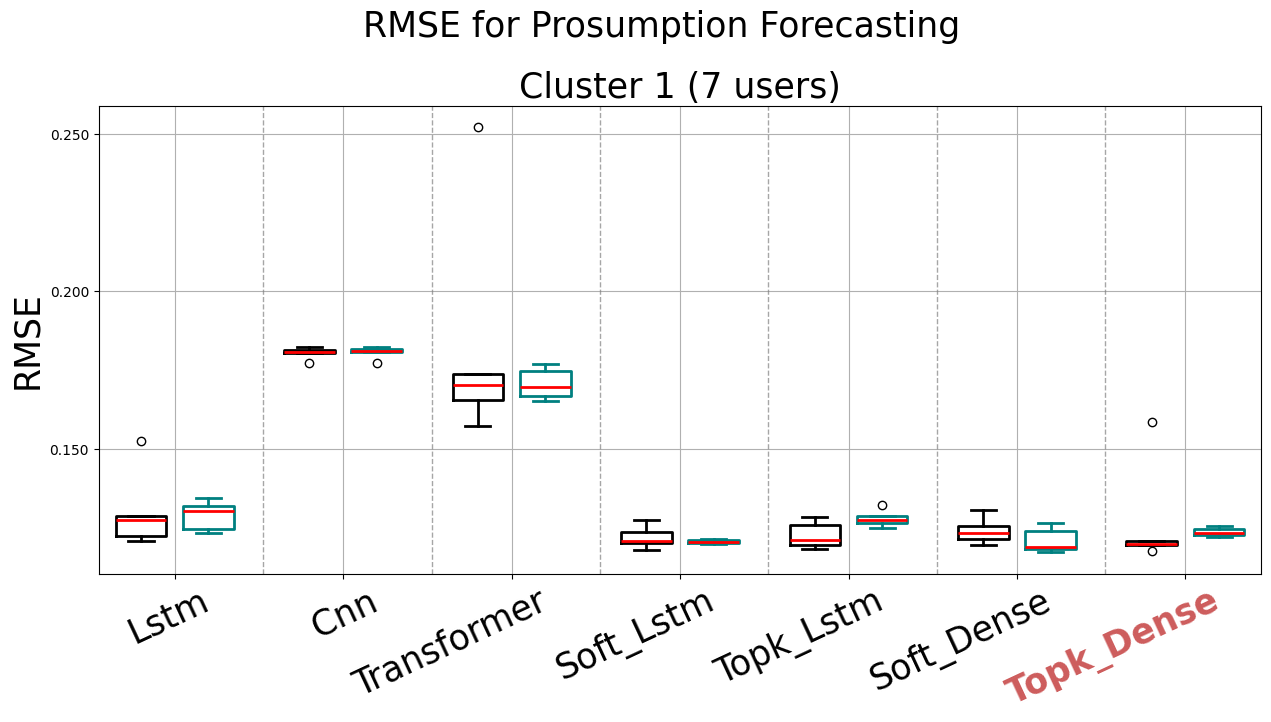

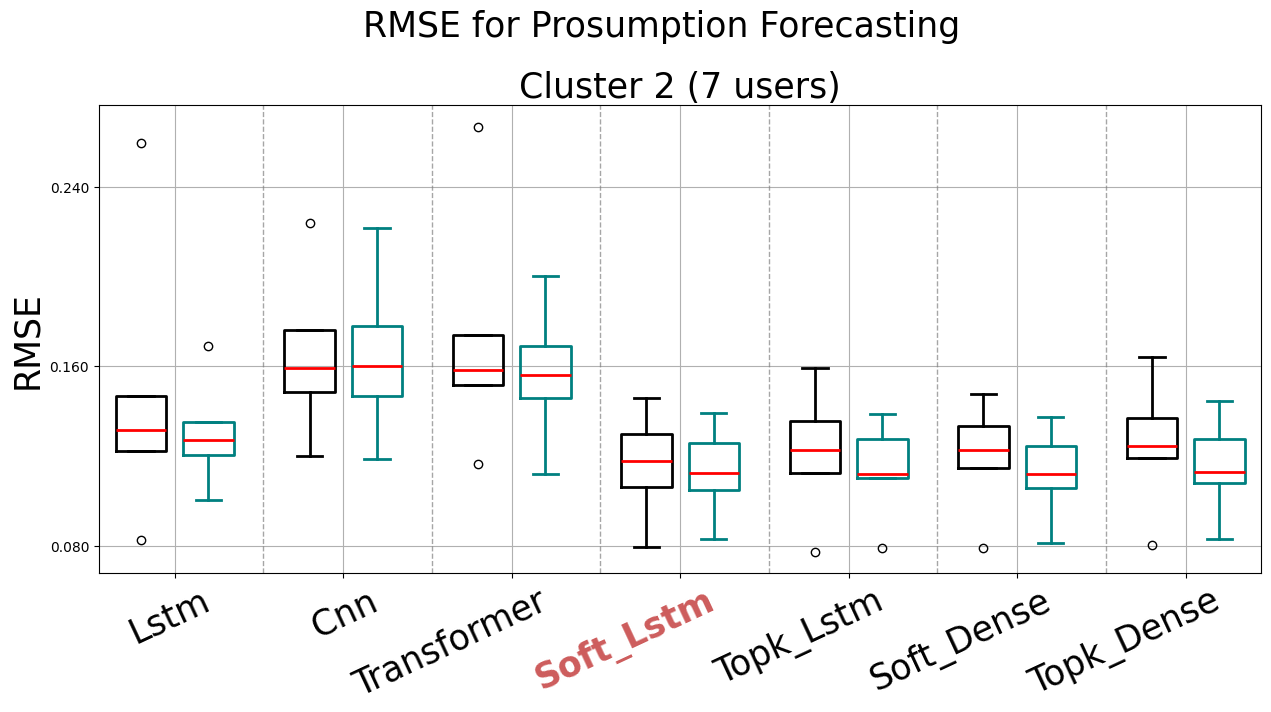

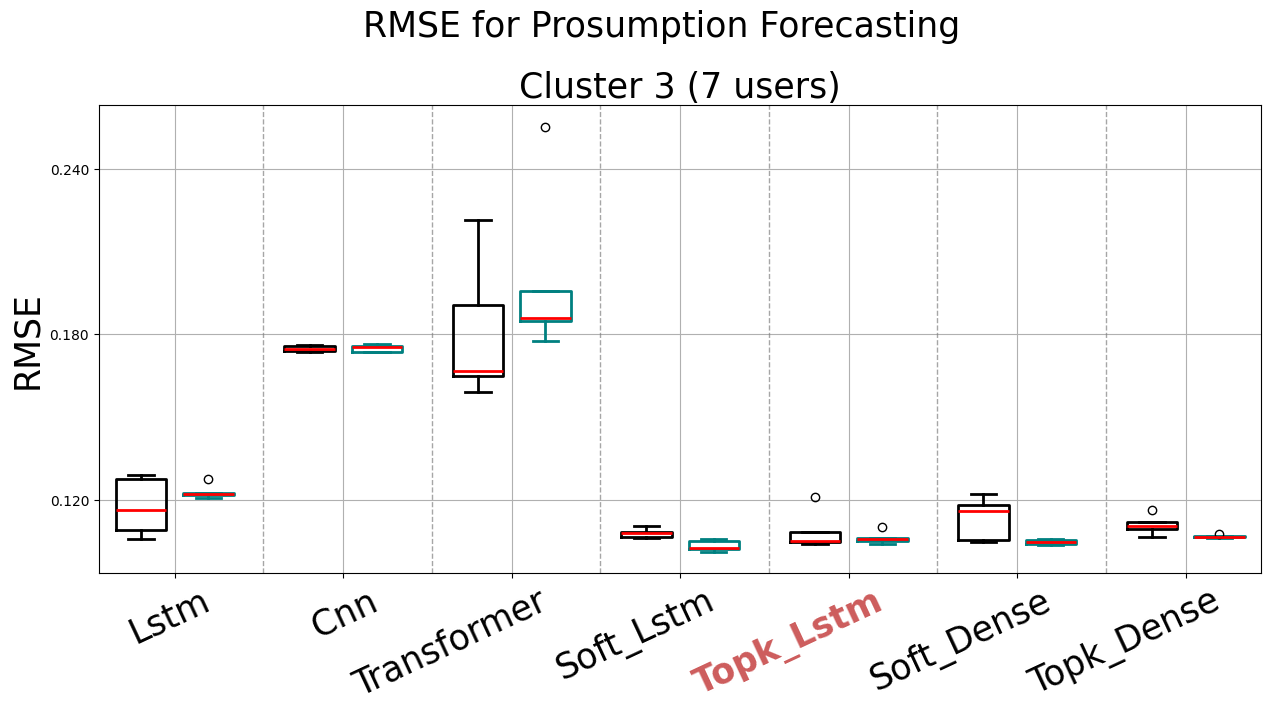

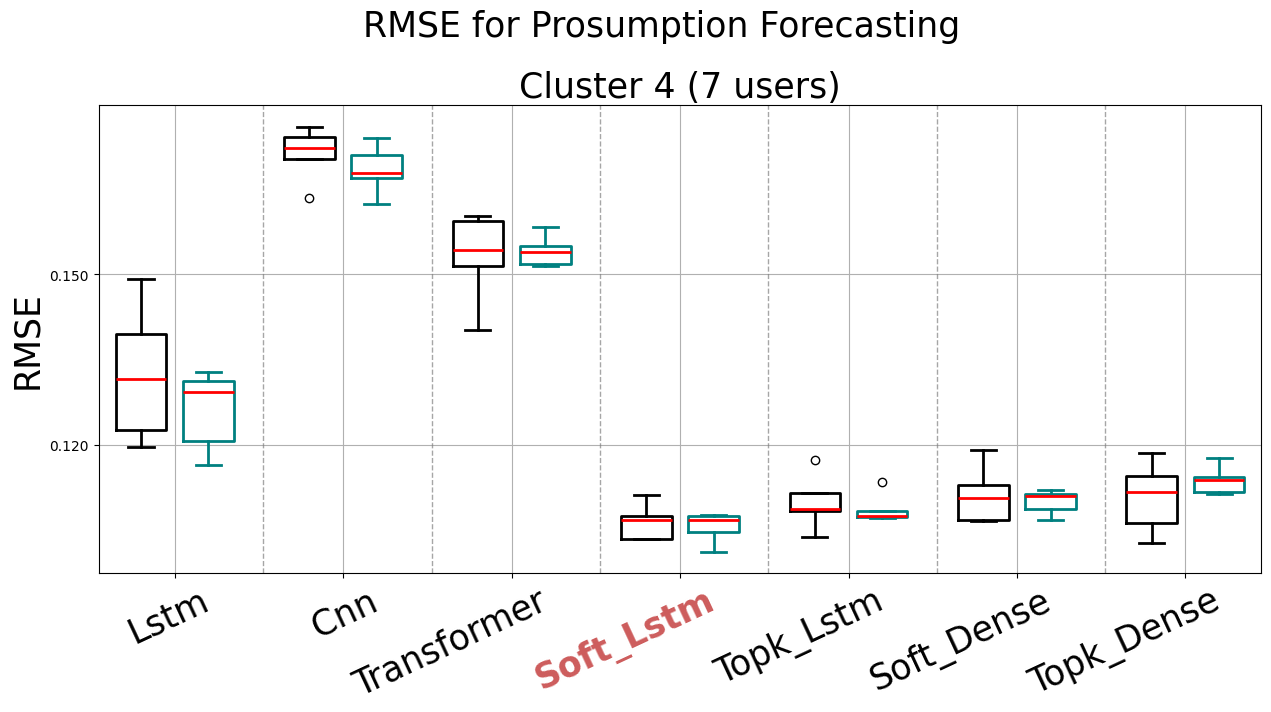

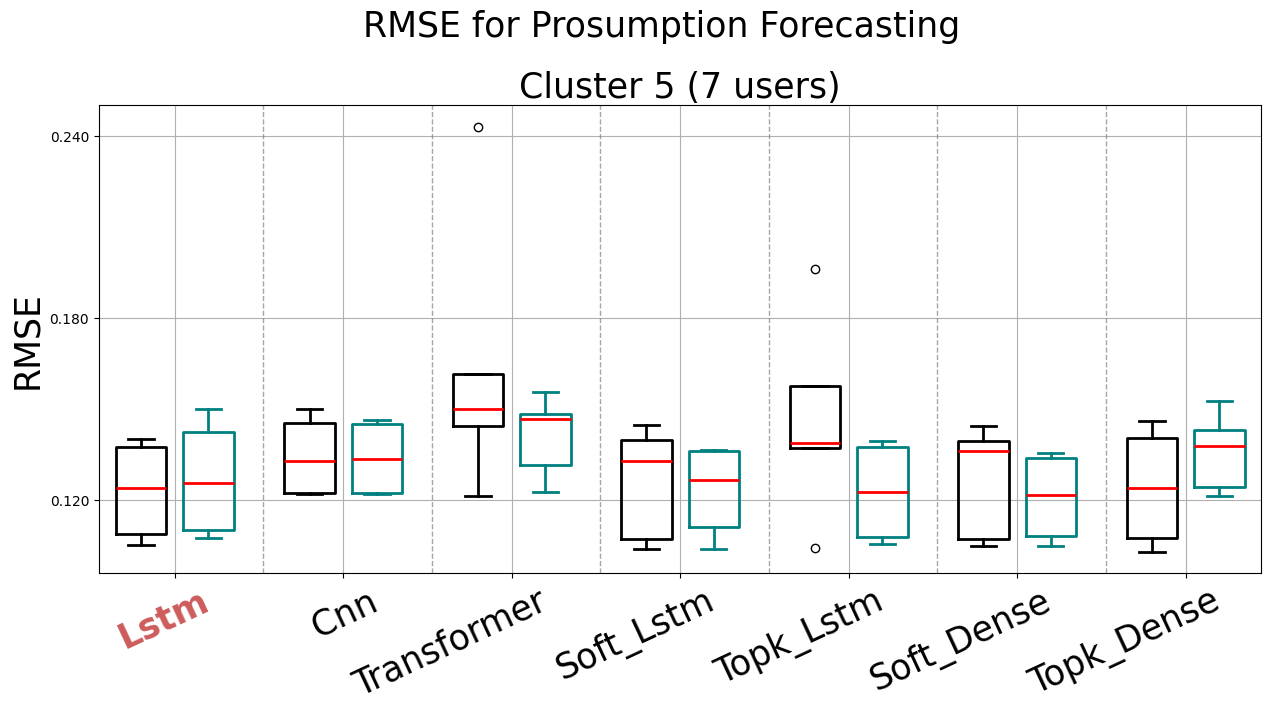

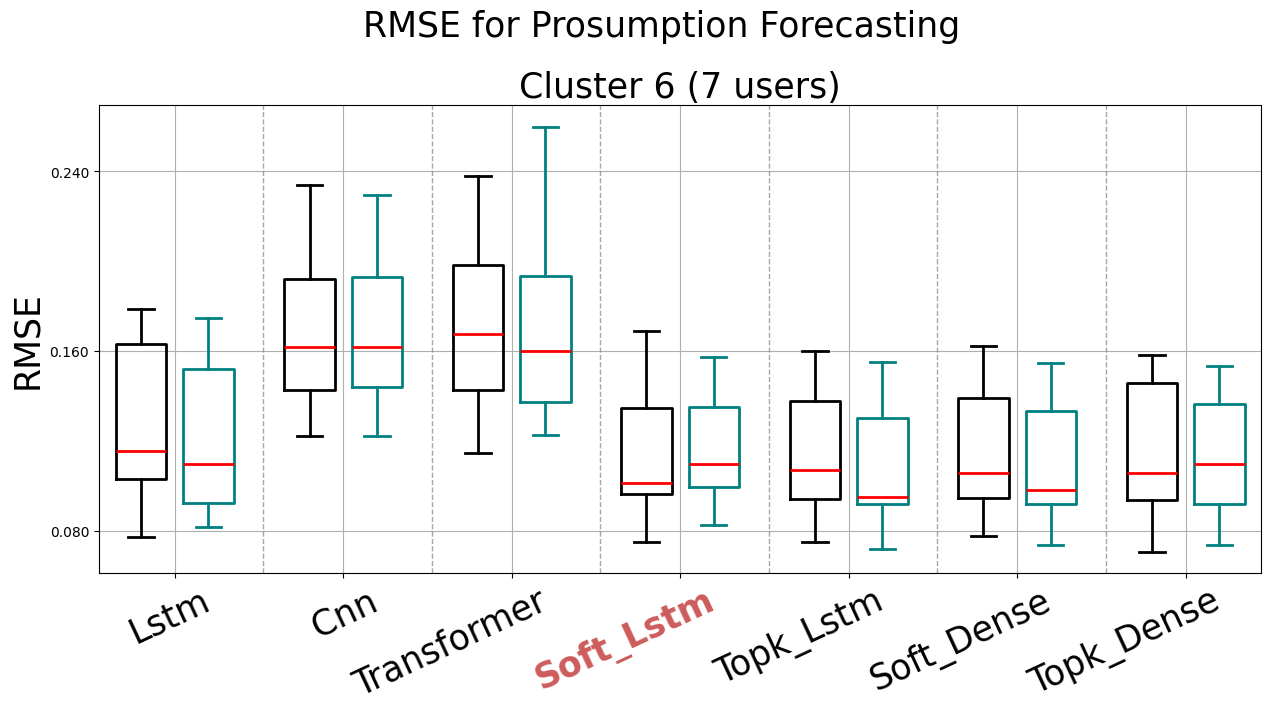

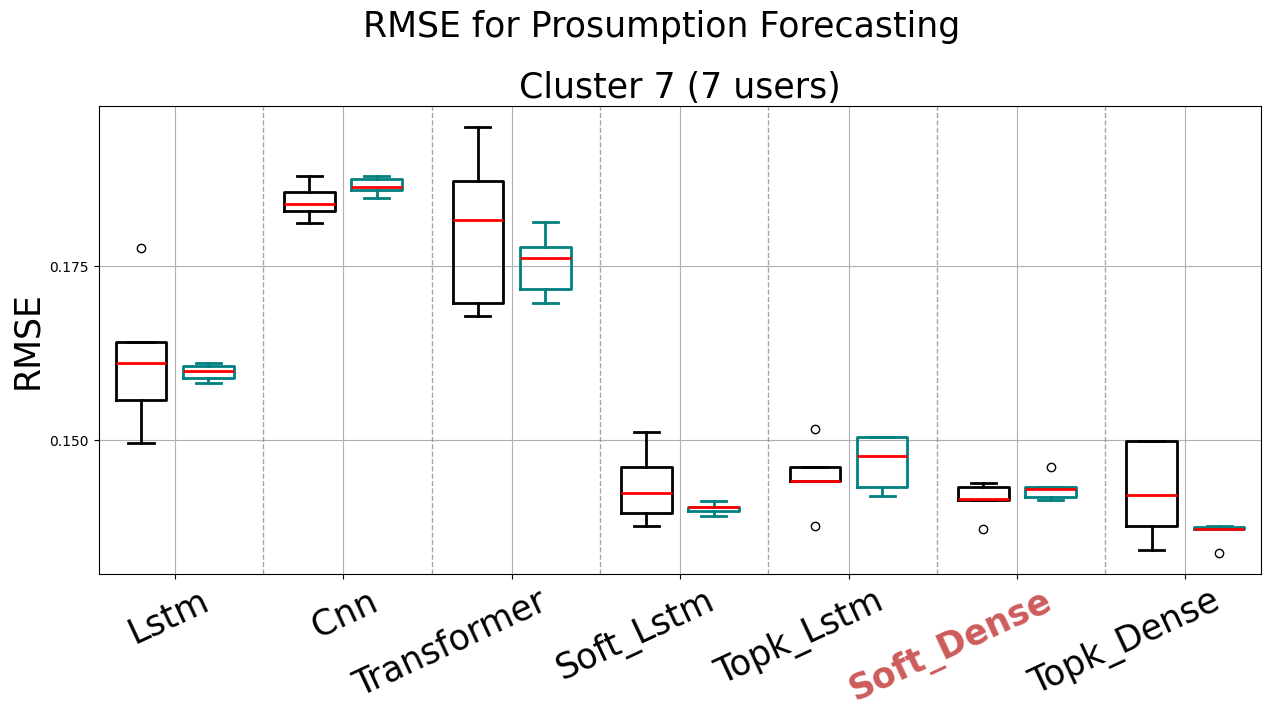

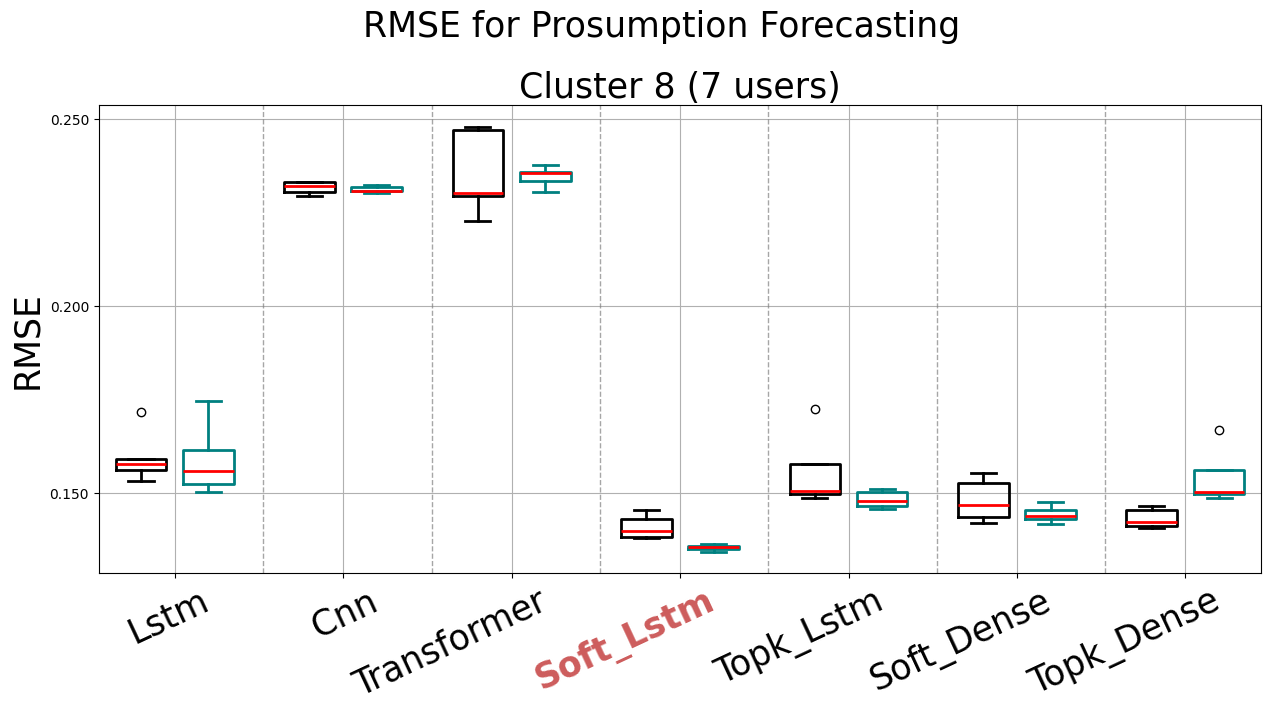

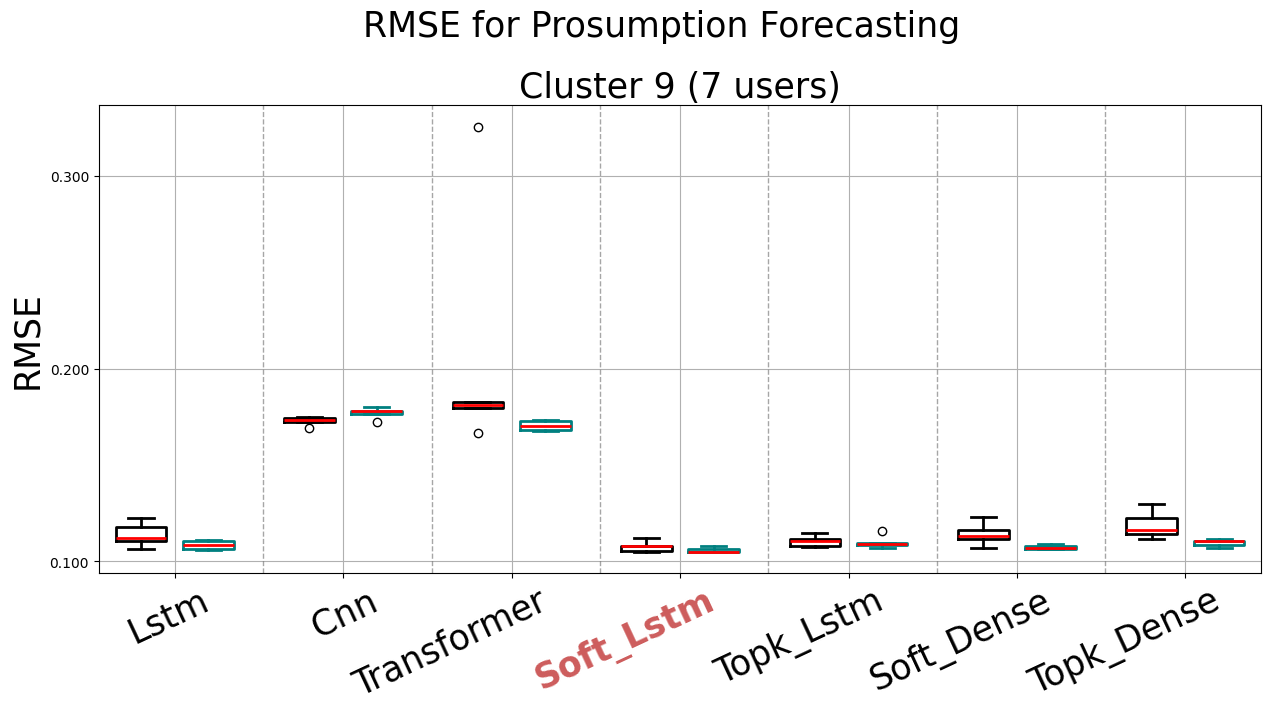

C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


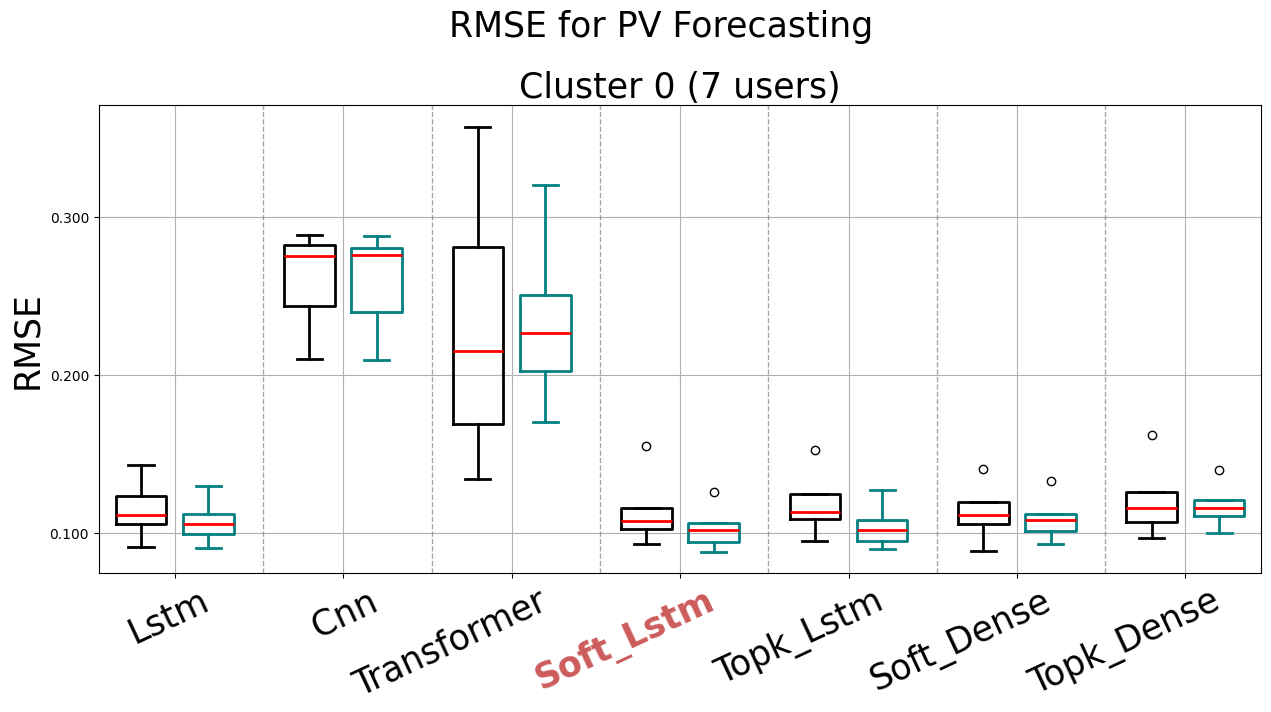

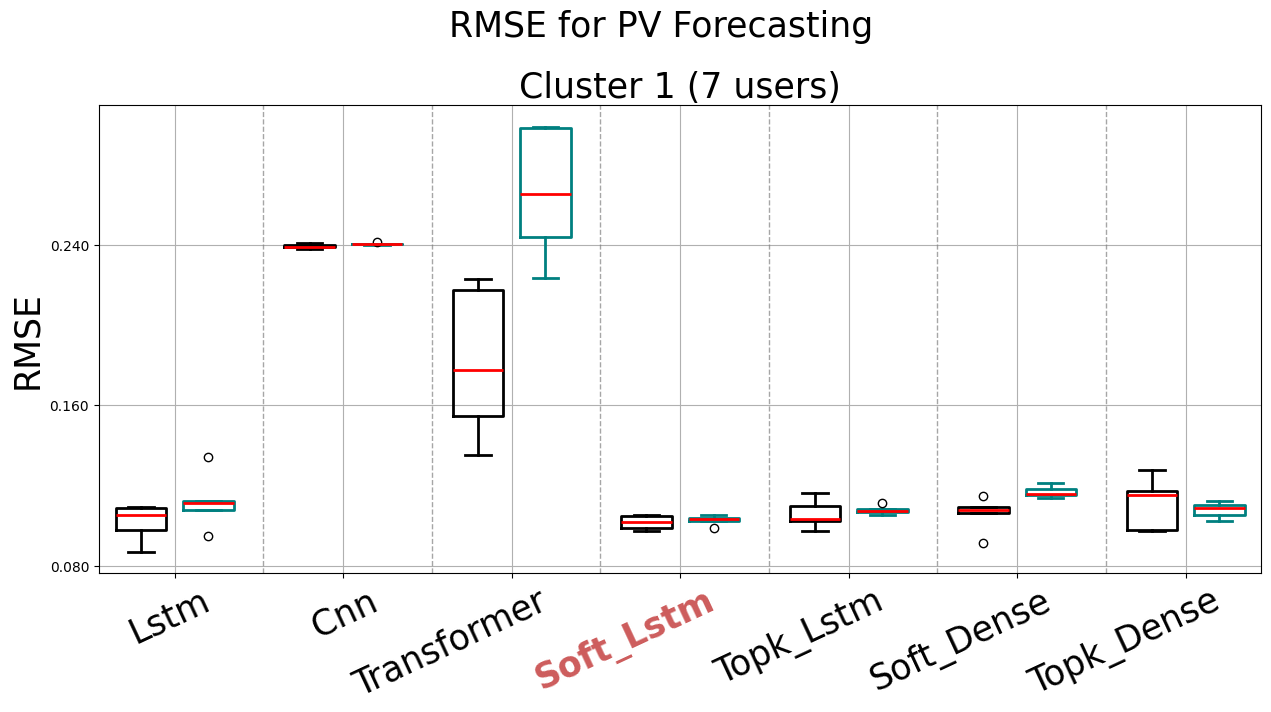

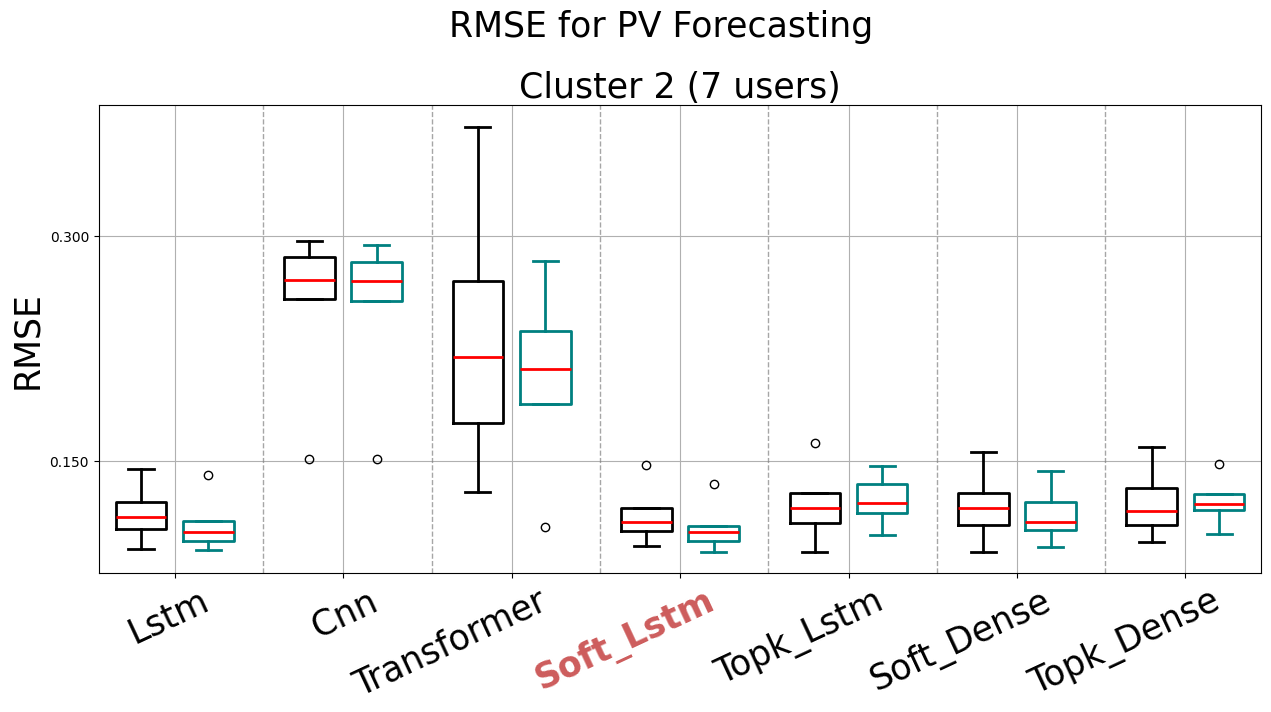

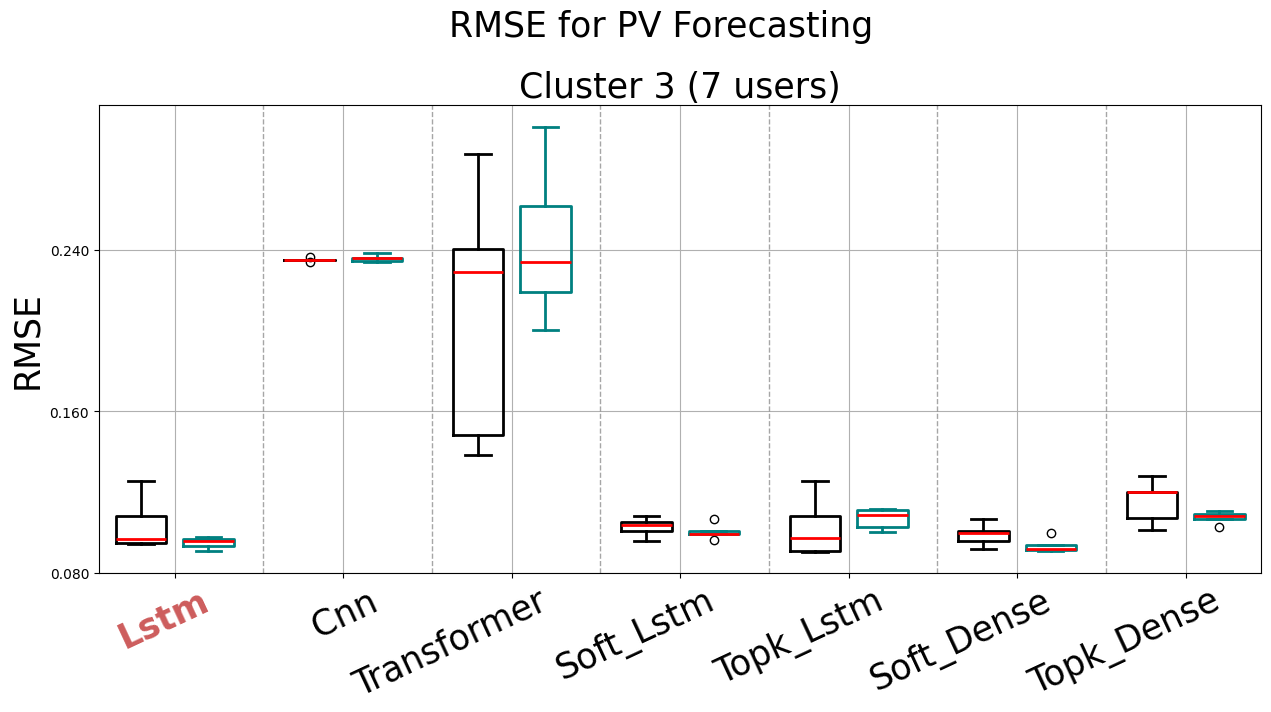

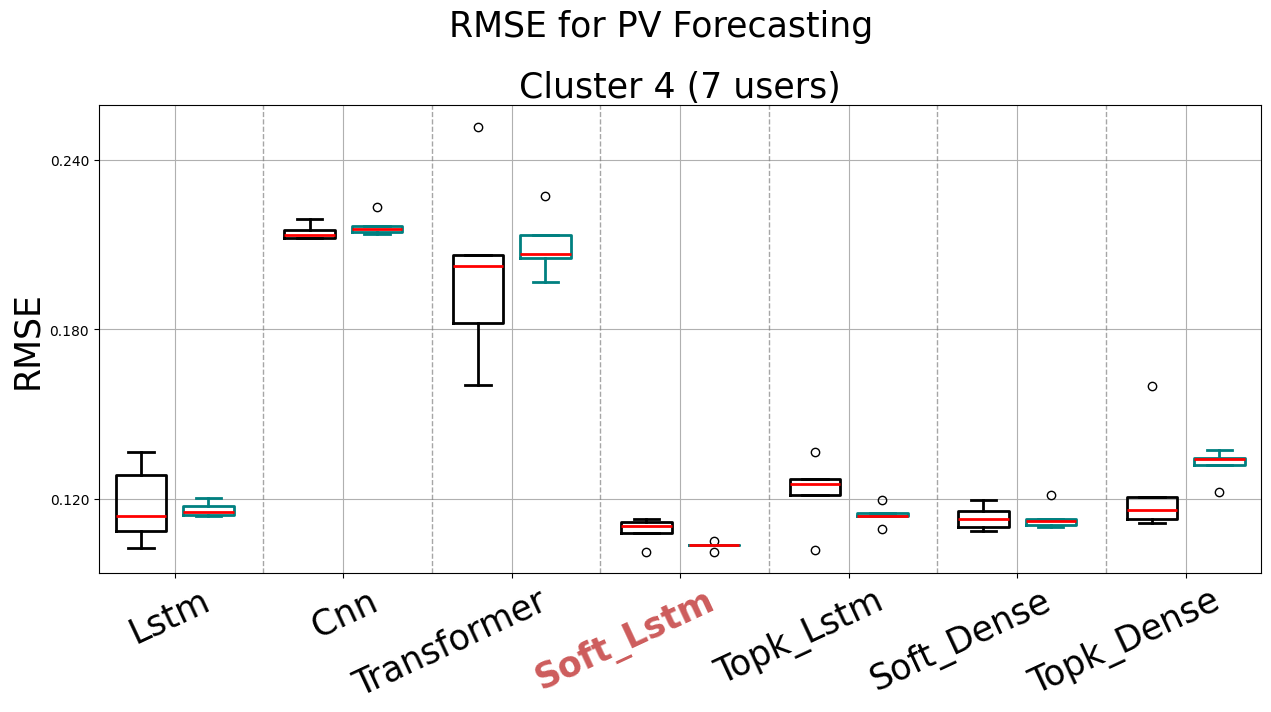

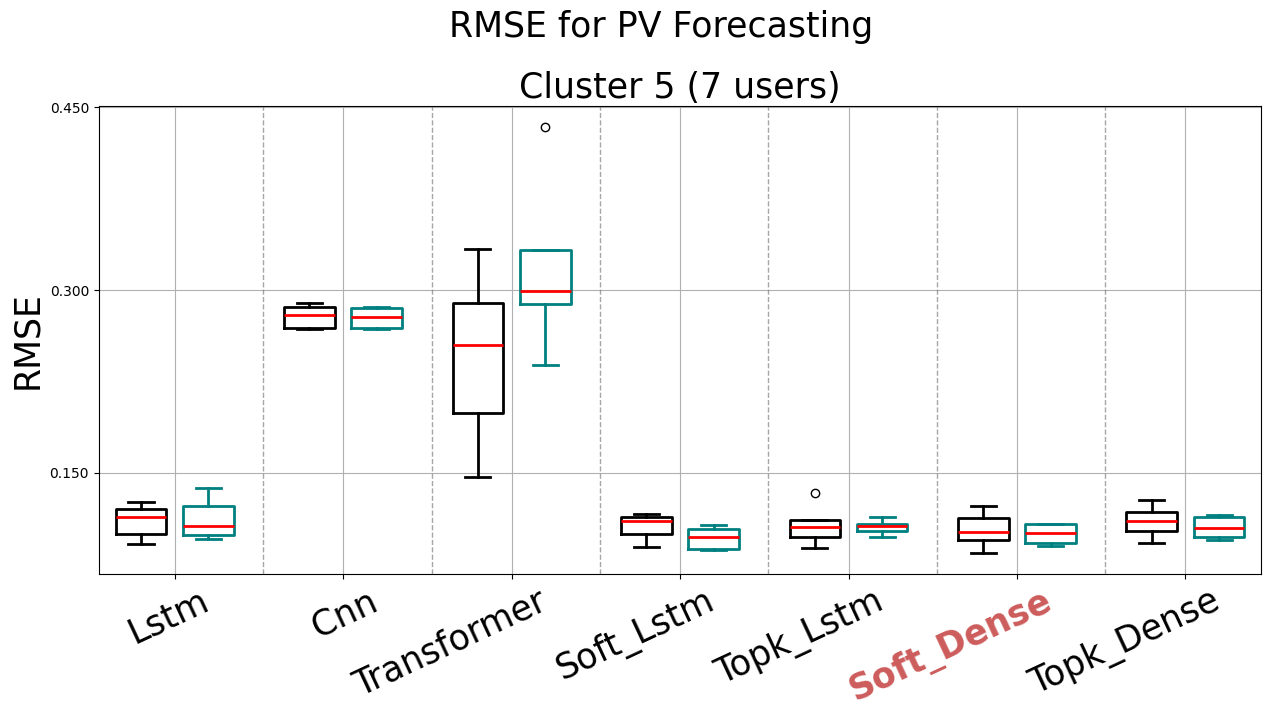

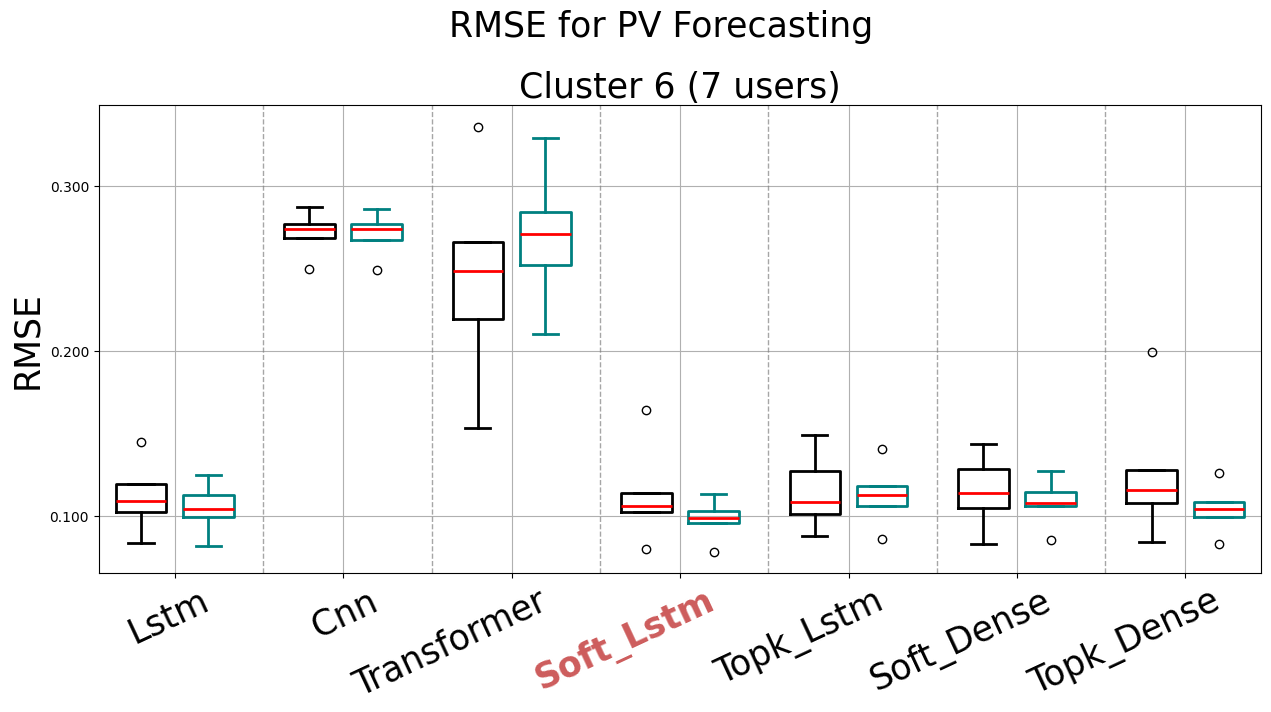

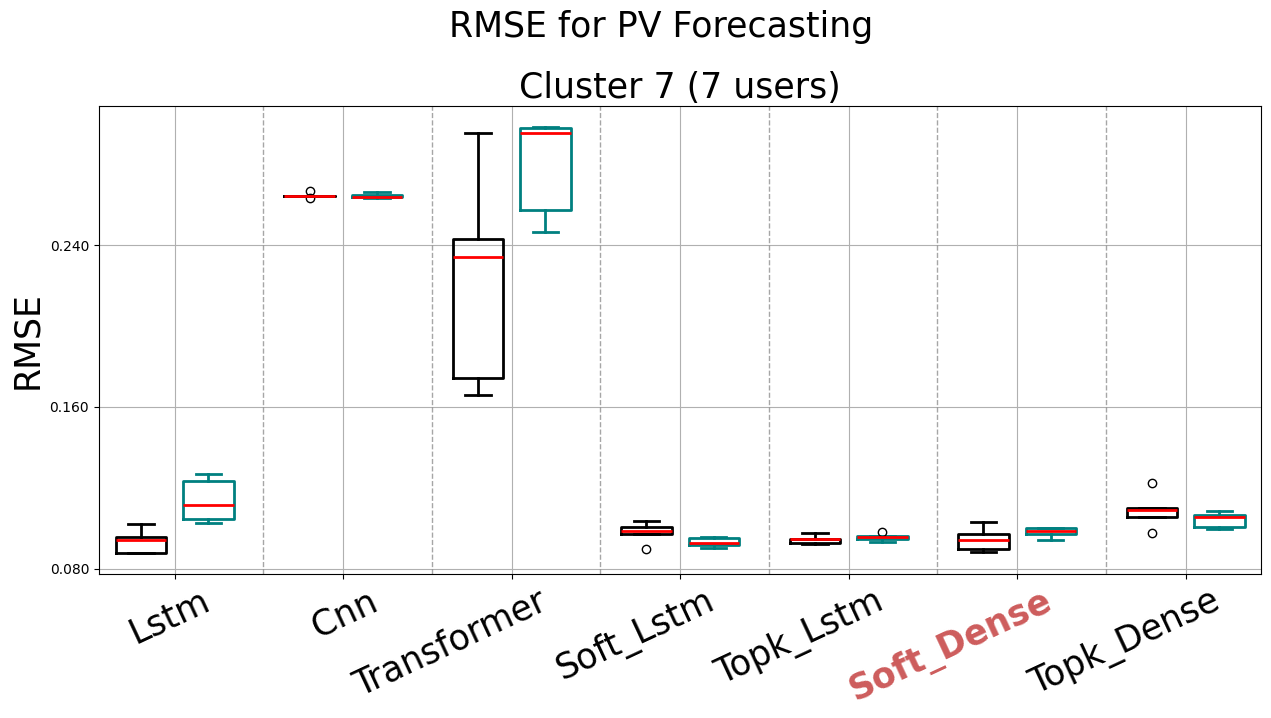

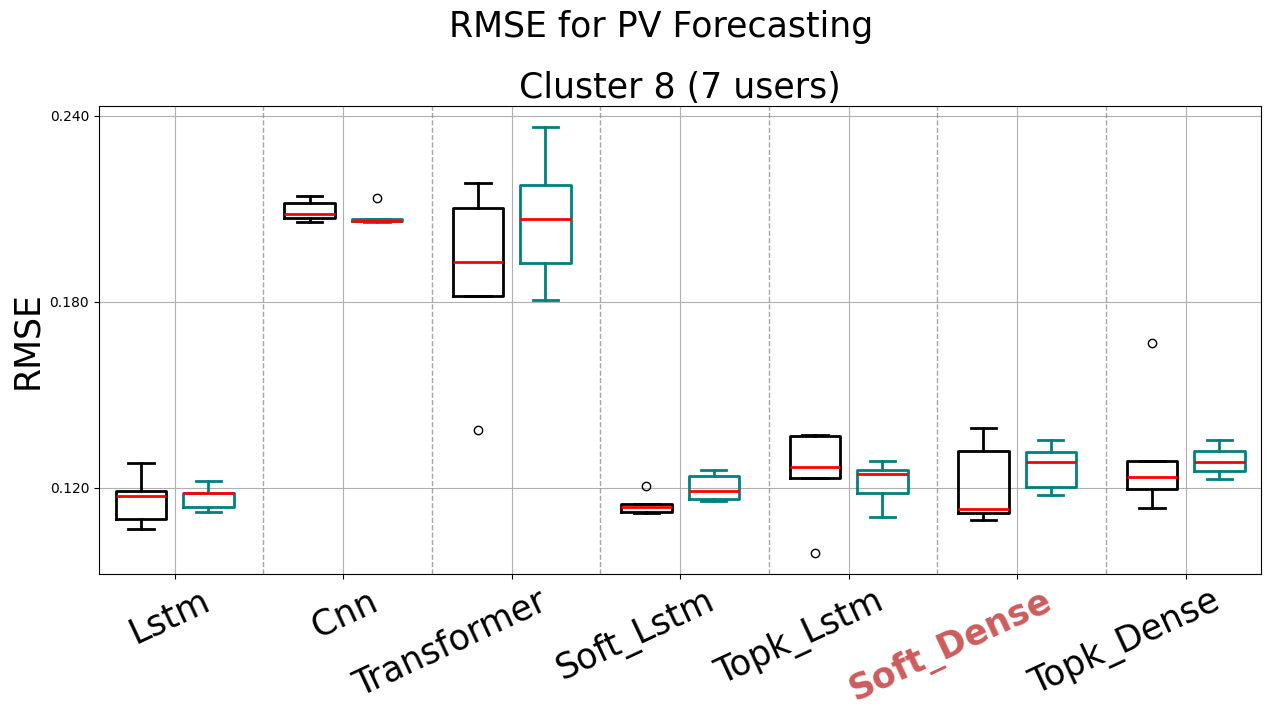

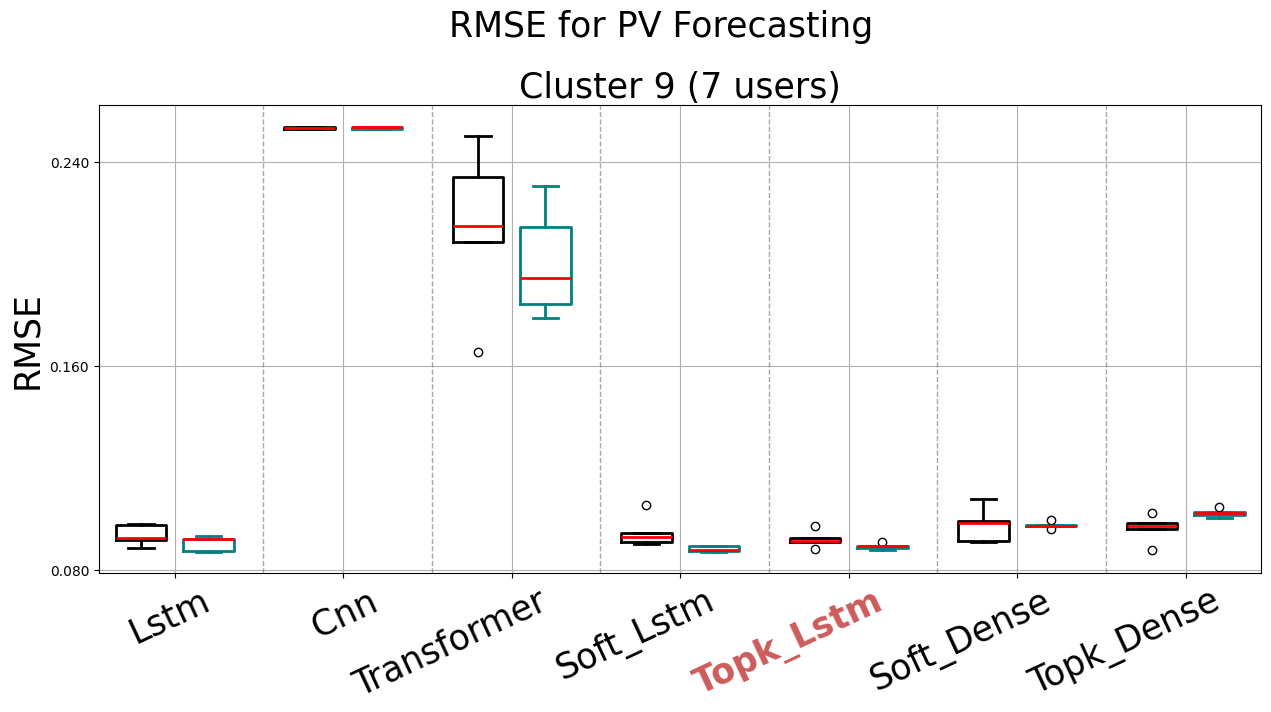

C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_16552\800066951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


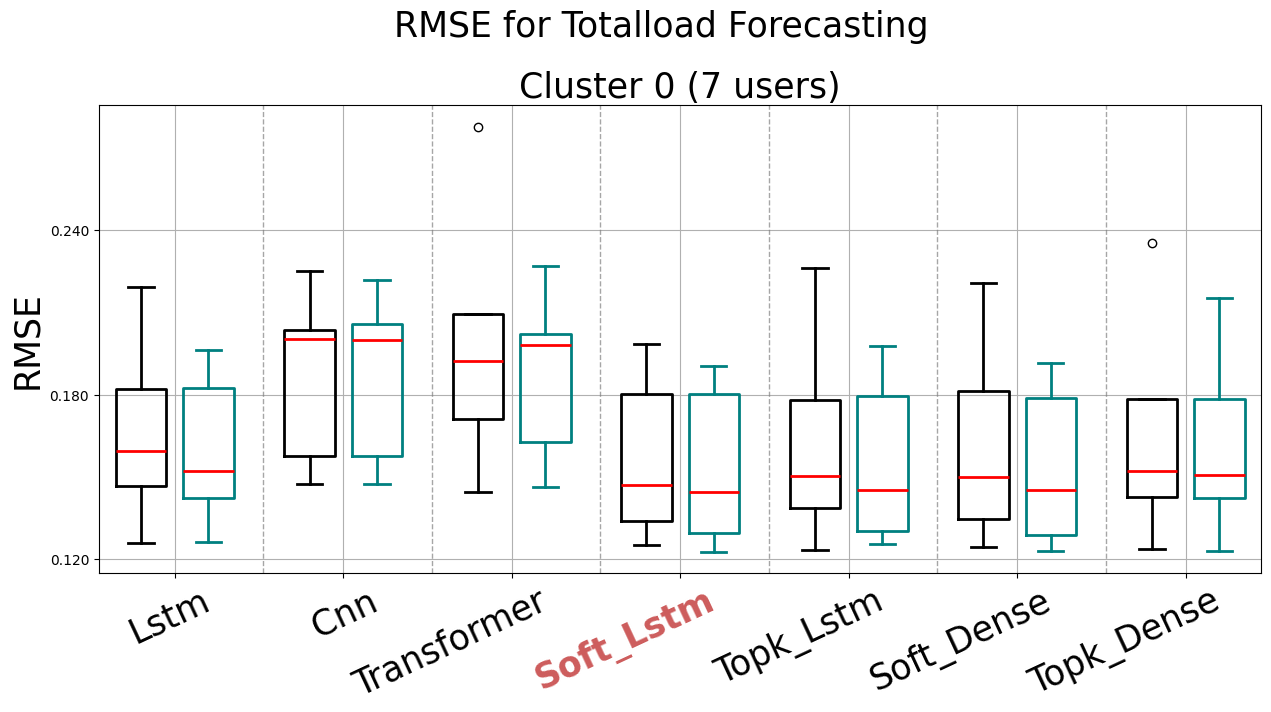

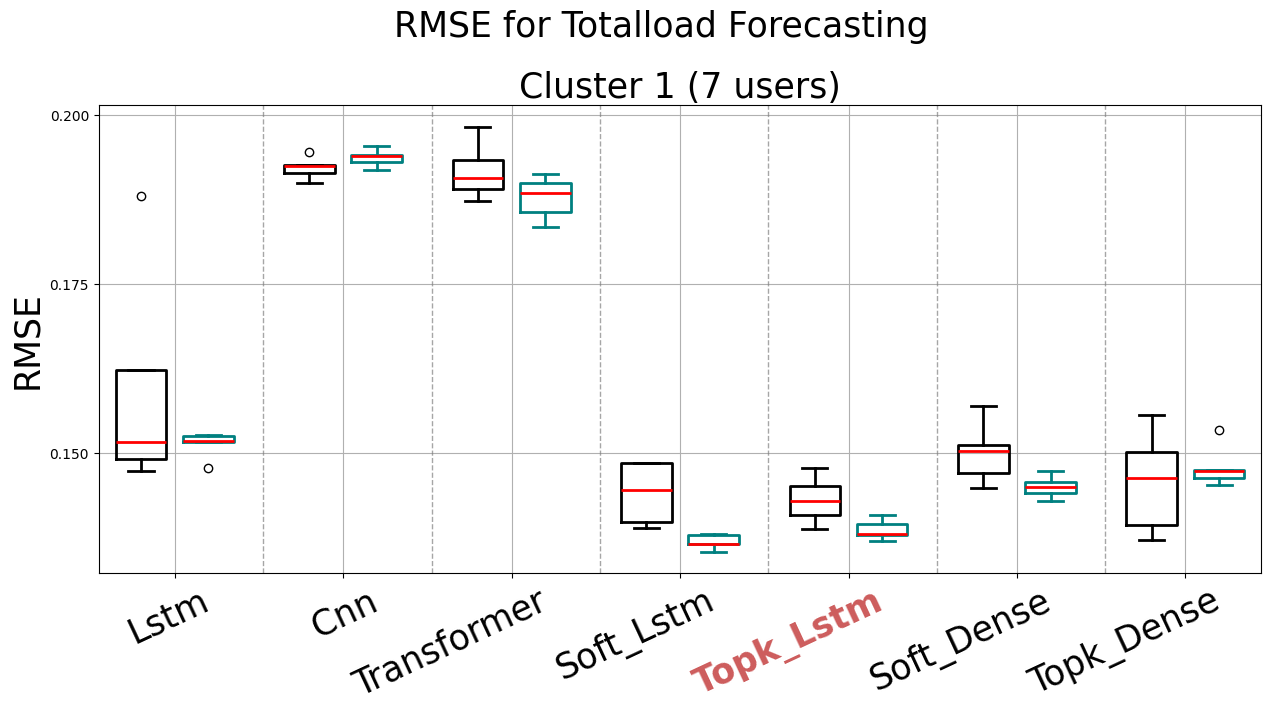

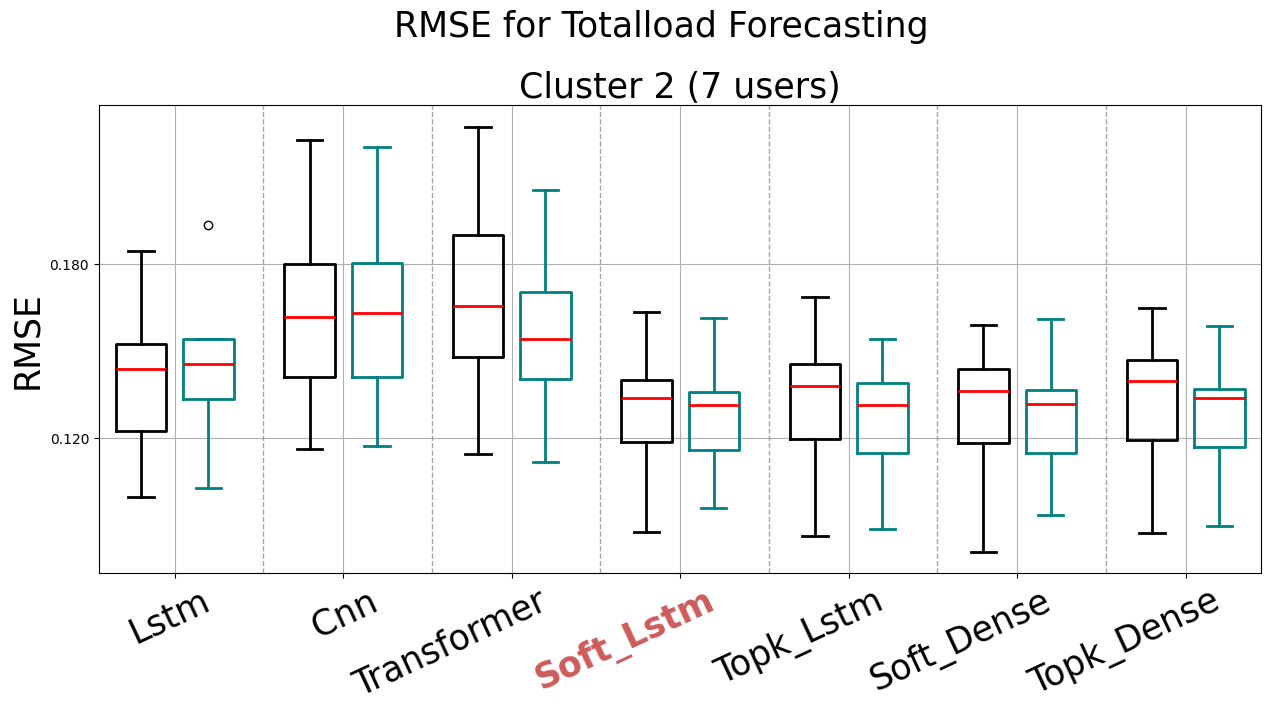

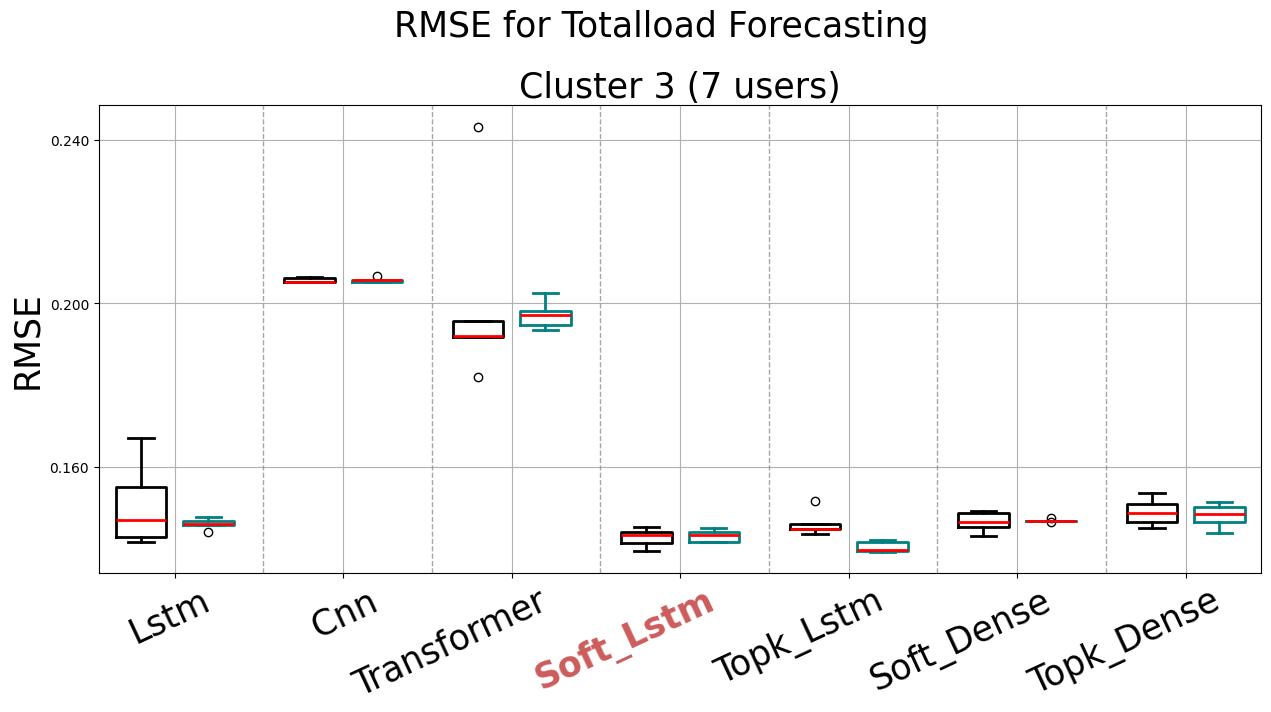

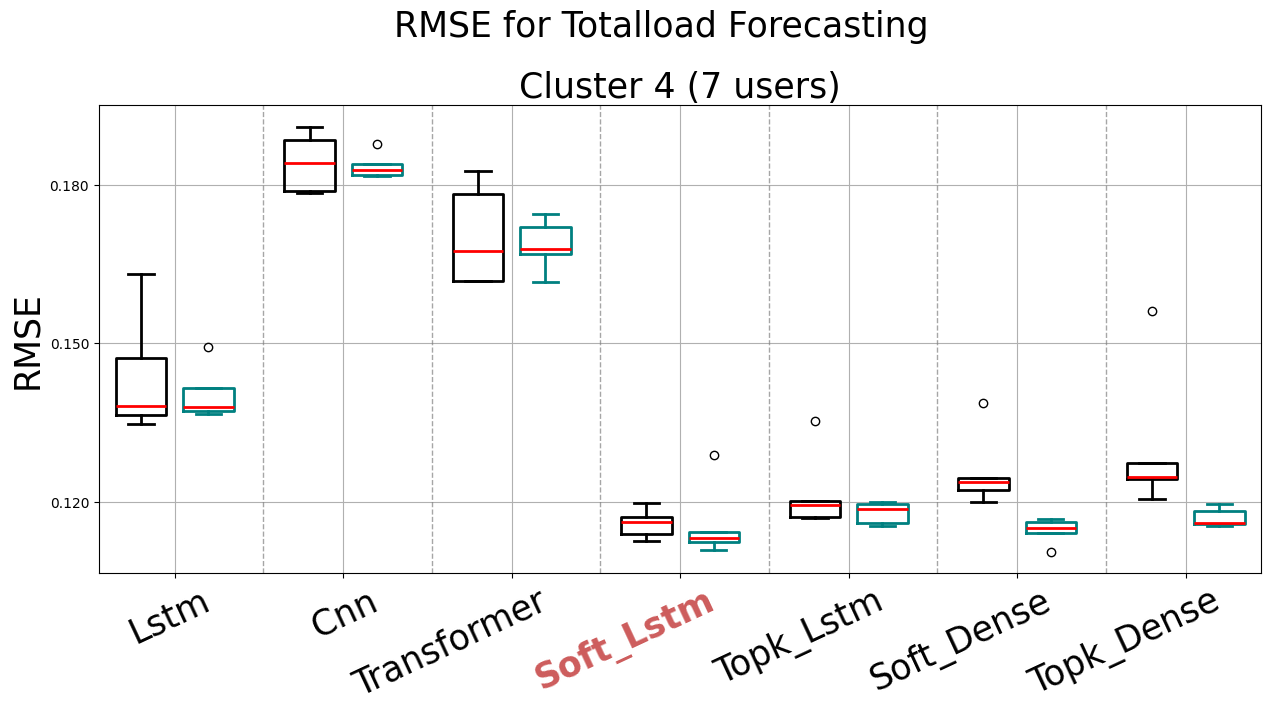

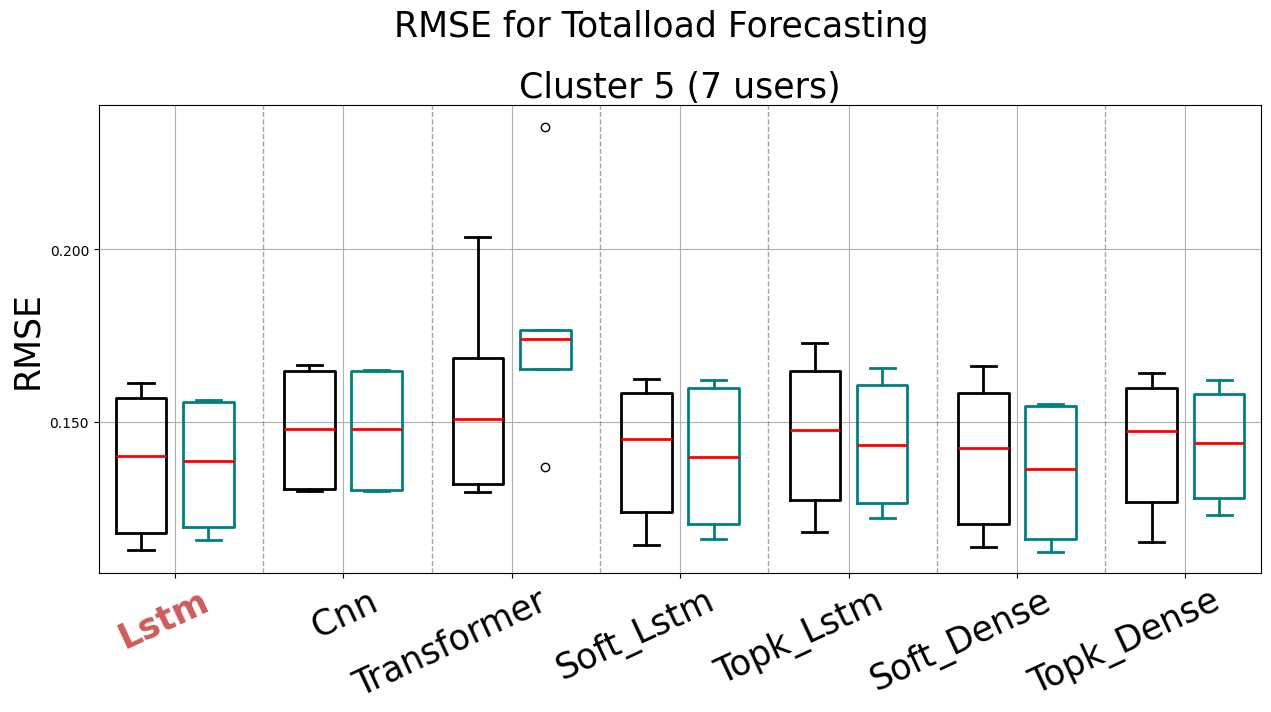

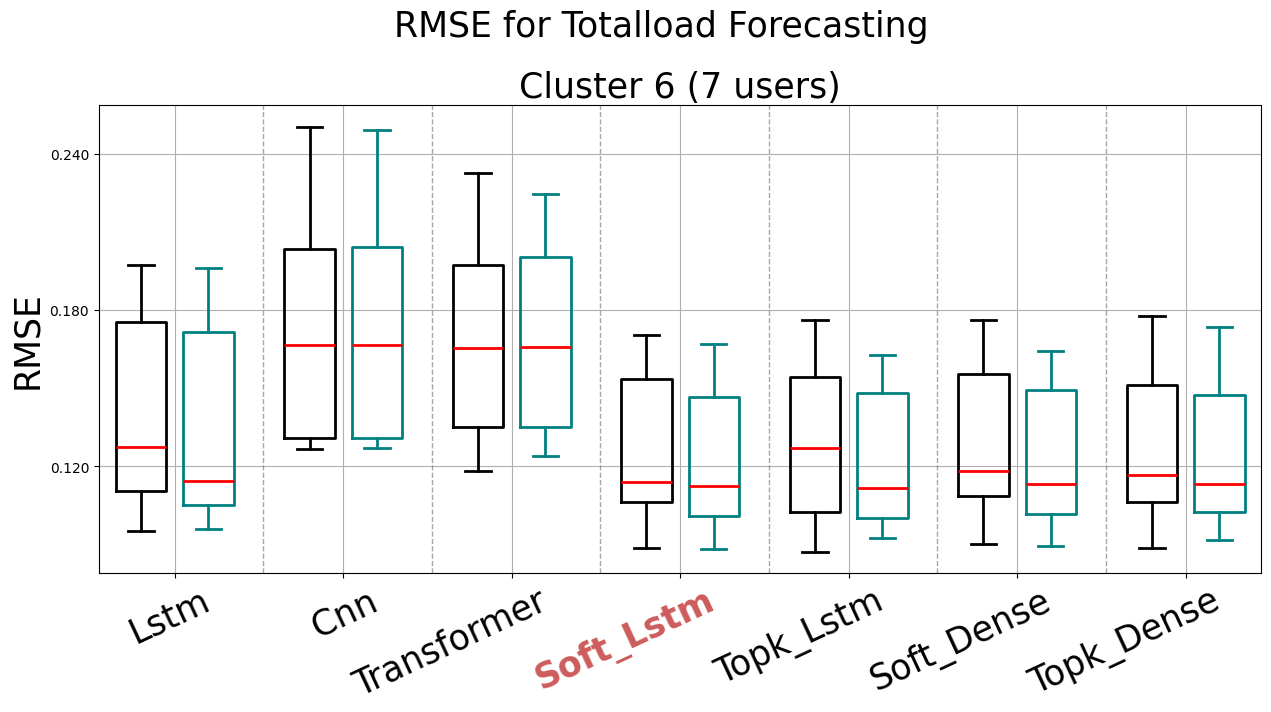

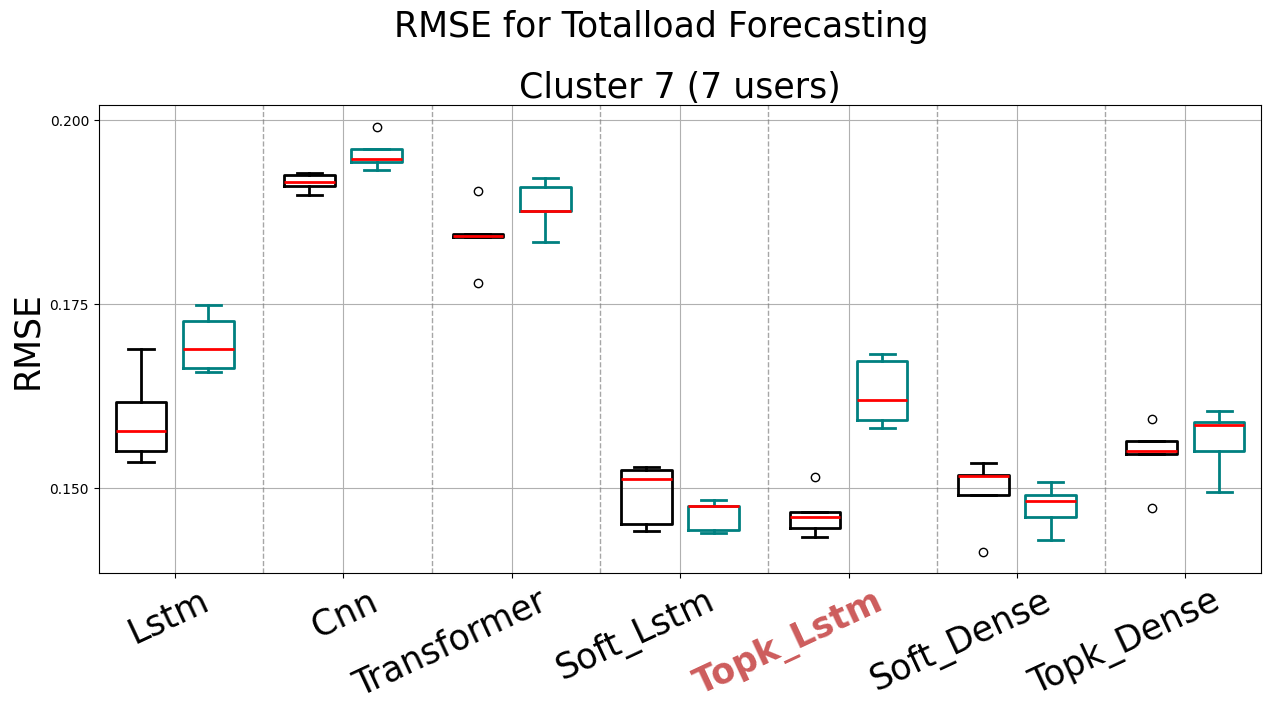

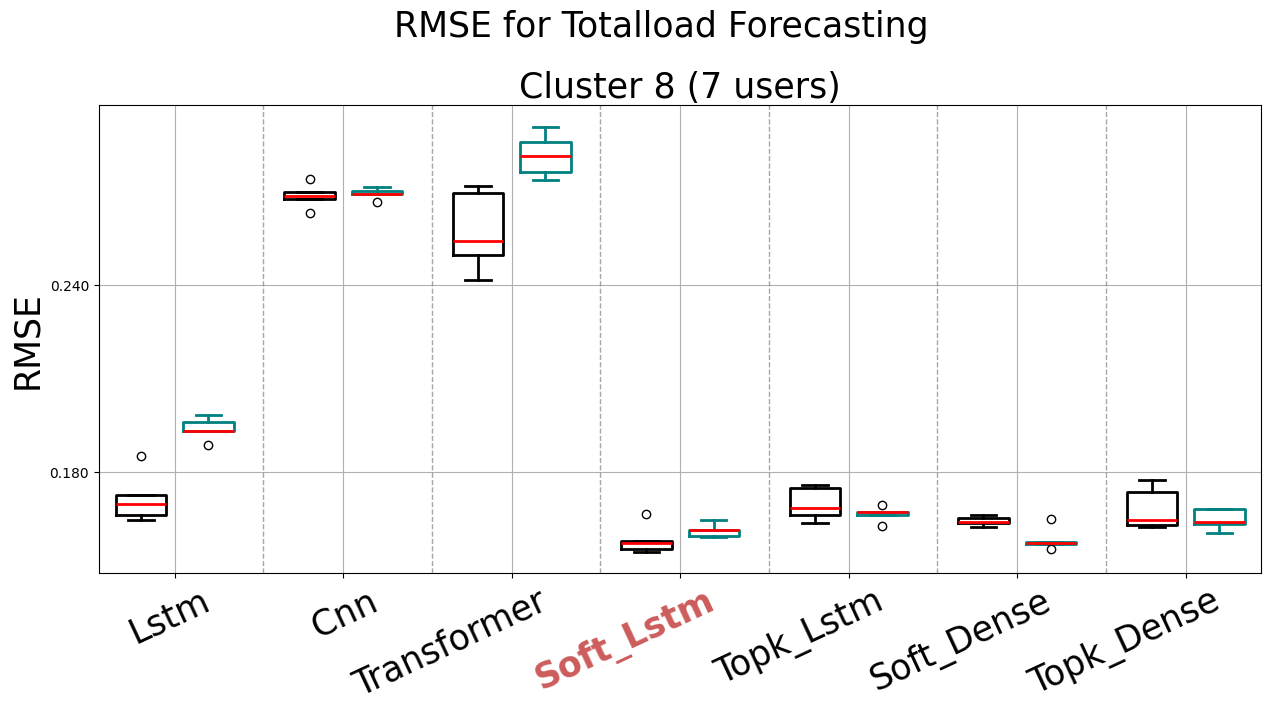

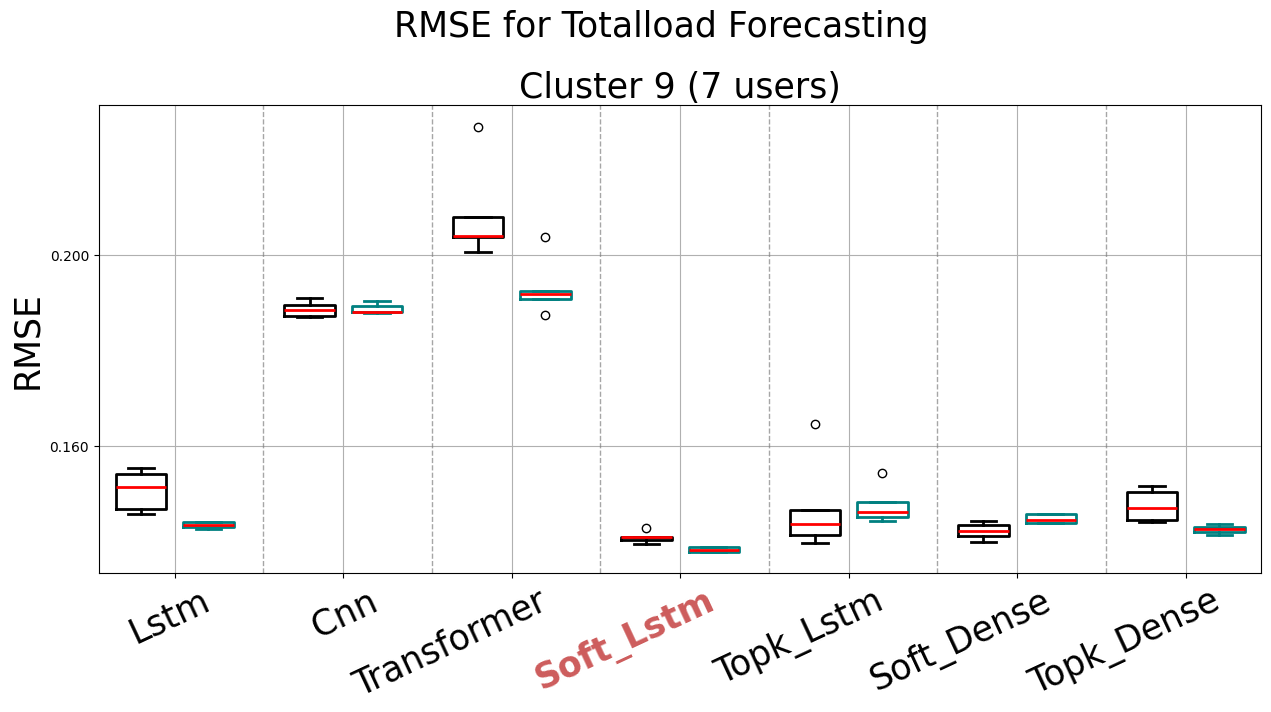

In [13]:
def plot_rmse_boxplot(df_ll, df_fl, num_clusters, use_case, figsize=(15, 6)):
    """
    Function to plot cluster-wise boxplots for RMSE values in the given DataFrames for LL and FL.
    """
    # Shorten model names by removing 'global_' prefix
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    fontsize = 25

    for cluster_number in range(num_clusters):
        cluster_data_ll = df_ll[df_ll['cluster'] == cluster_number]
        cluster_data_fl = df_fl[df_fl['cluster'] == cluster_number]

        # Extract boxplot data for LL and FL
        boxplot_data_ll = cluster_data_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
        boxplot_data_fl = cluster_data_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

        plt.figure(figsize=figsize)
        ax = plt.subplot(111)

        # Plot Local Learning boxplots
        boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        # Plot Federated Learning boxplots in green
        boxplot_data_fl.boxplot(positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        plt.ylabel('RMSE', fontsize=fontsize)

        x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
        x_labels = boxplot_data_ll.columns
        lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
        for i, label in enumerate(x_labels):
            if label == lowest_median_label:
                ax.get_xticklabels()[i].set_color("indianred")
                ax.get_xticklabels()[i].set_weight("bold")

        offset = 0.4
        for label in ax.get_xticklabels():
            transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
            label.set_transform(transform)

        plt.xticks(x_ticks, x_labels, rotation=25, ha='right', fontsize=fontsize)

        for i in range(1, len(x_ticks)):
            plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

        # Set y-axis format
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        plt.title(f'Cluster {cluster_number} ({len(cluster_data_ll)} {"user" if len(cluster_data_ll) == 1 else "users"})', y=1, fontsize=fontsize)
        plt.ylabel('RMSE', fontsize=fontsize)

        plt.suptitle(get_plot_title(use_case), fontsize=fontsize, y=1.05)
        plt.subplots_adjust(hspace=2, top=0.89)  # Increase space between rows
        plt.show()

# Assuming you have separate DataFrames df_ll and df_fl for LL and FL metrics
num_clusters = 10  # Assuming 10 clusters
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case and each cluster
for use_case in use_cases:
    df_ll_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'LL_{use_case}')]
    df_fl_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'FL_{use_case}')]
    plot_rmse_boxplot(df_ll_use_case, df_fl_use_case, num_clusters, use_case)


C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


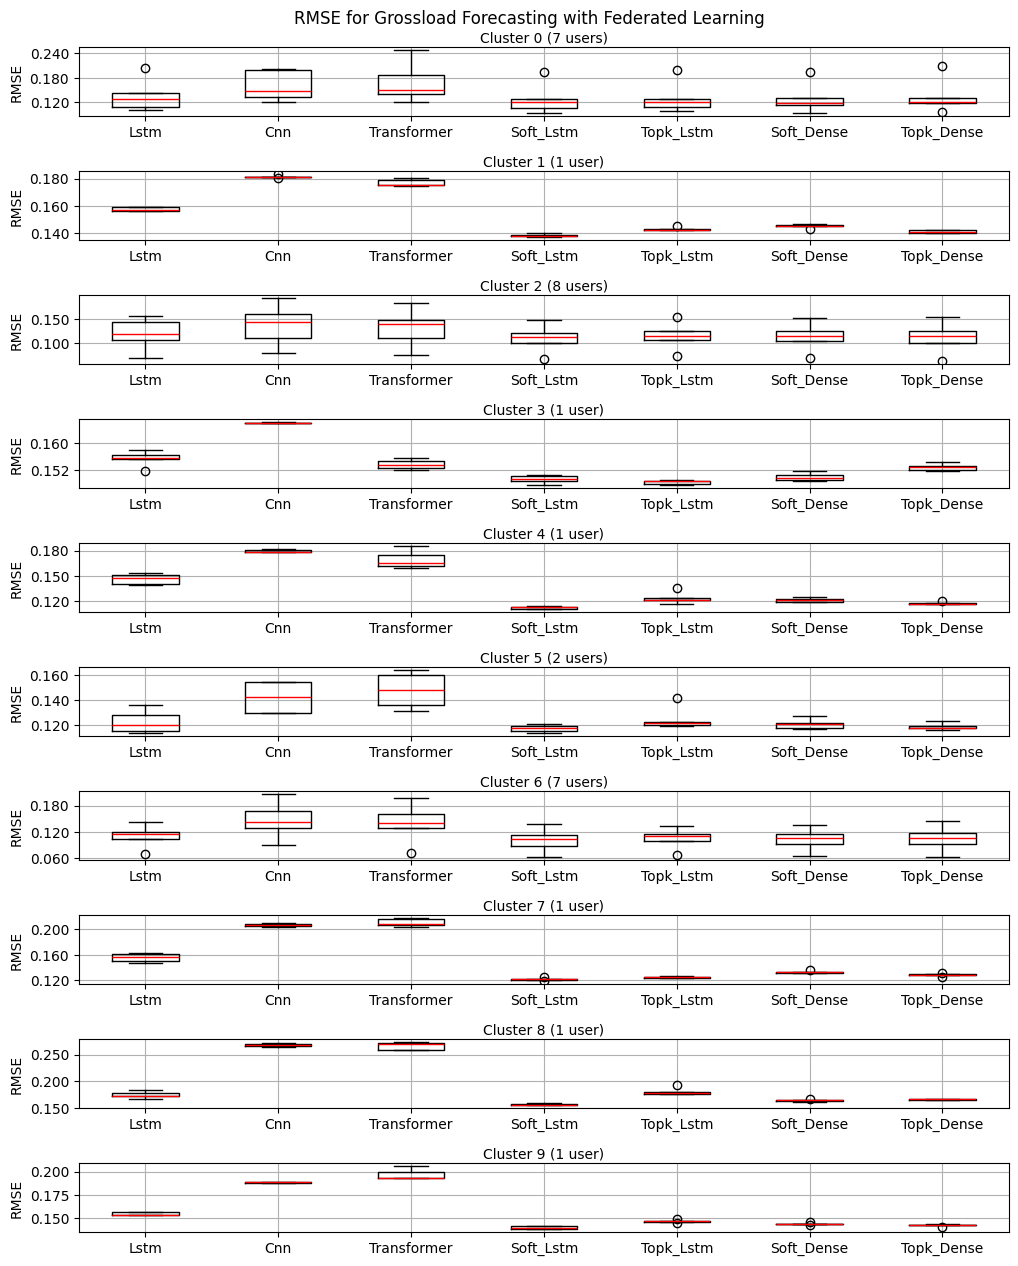

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


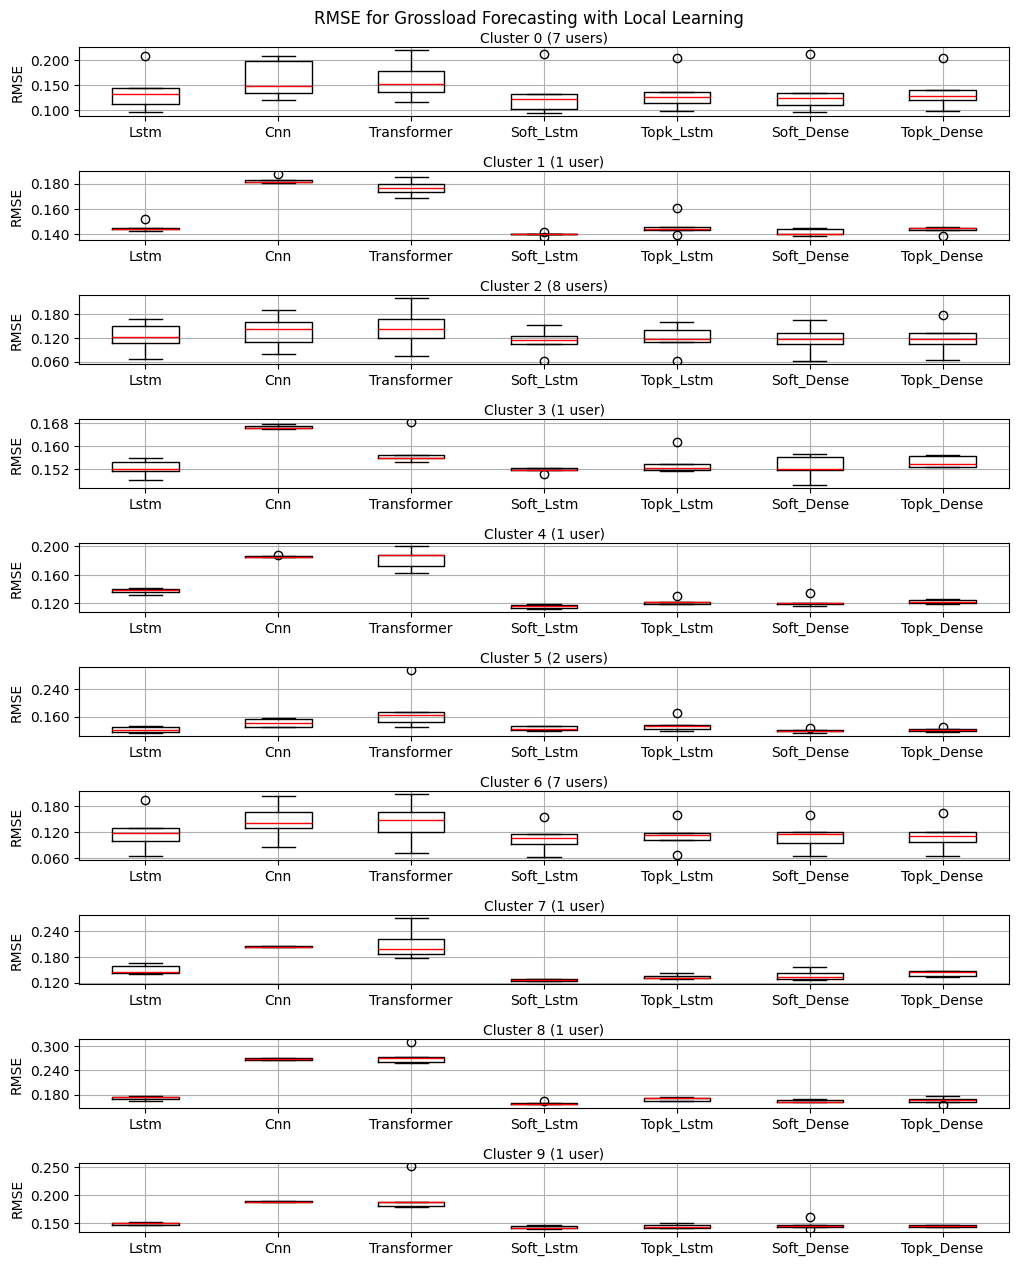

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


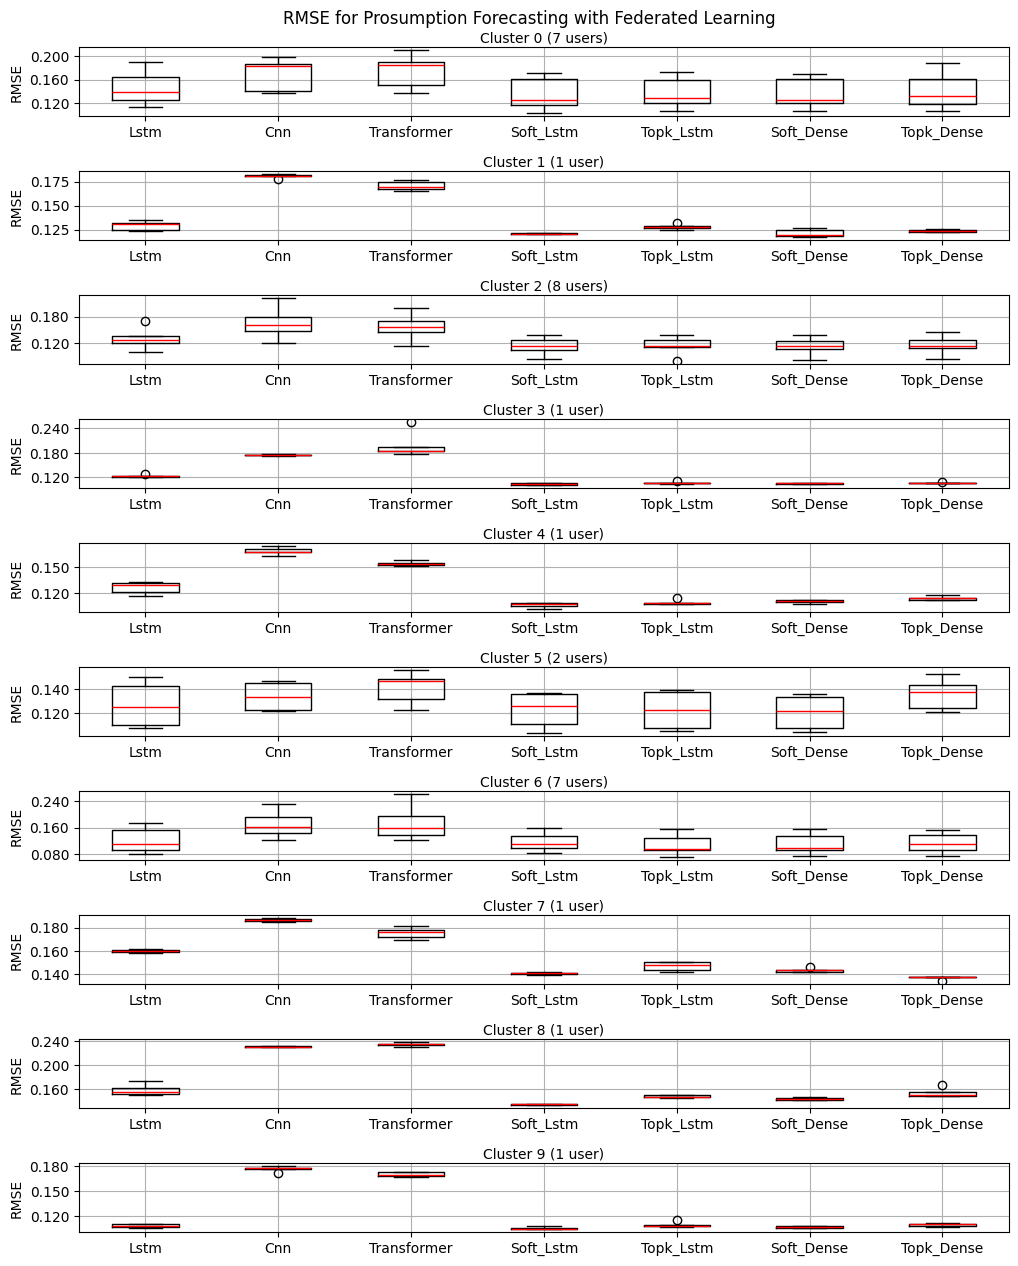

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


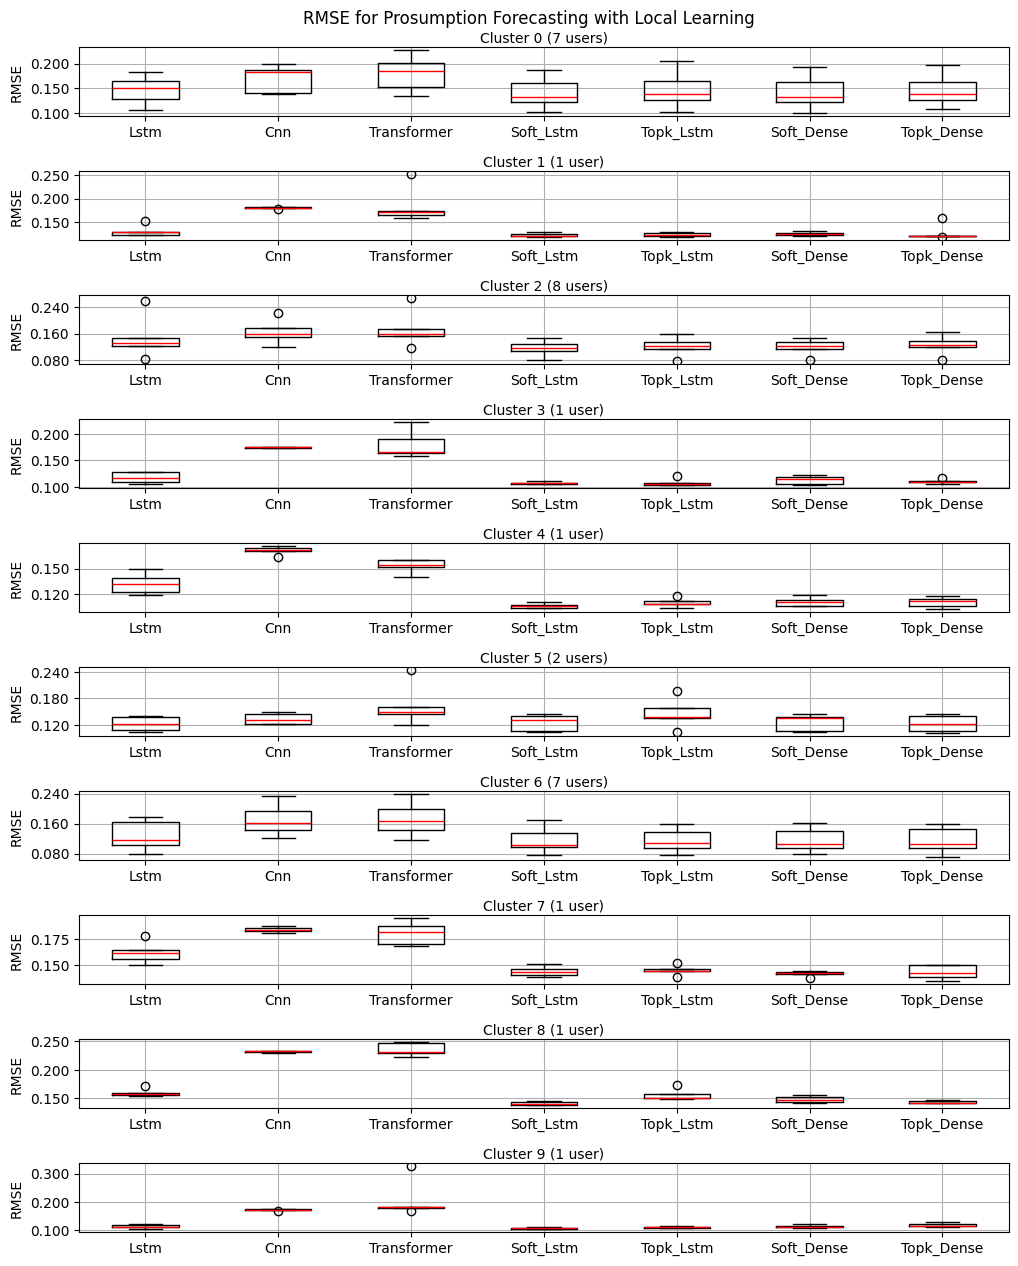

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


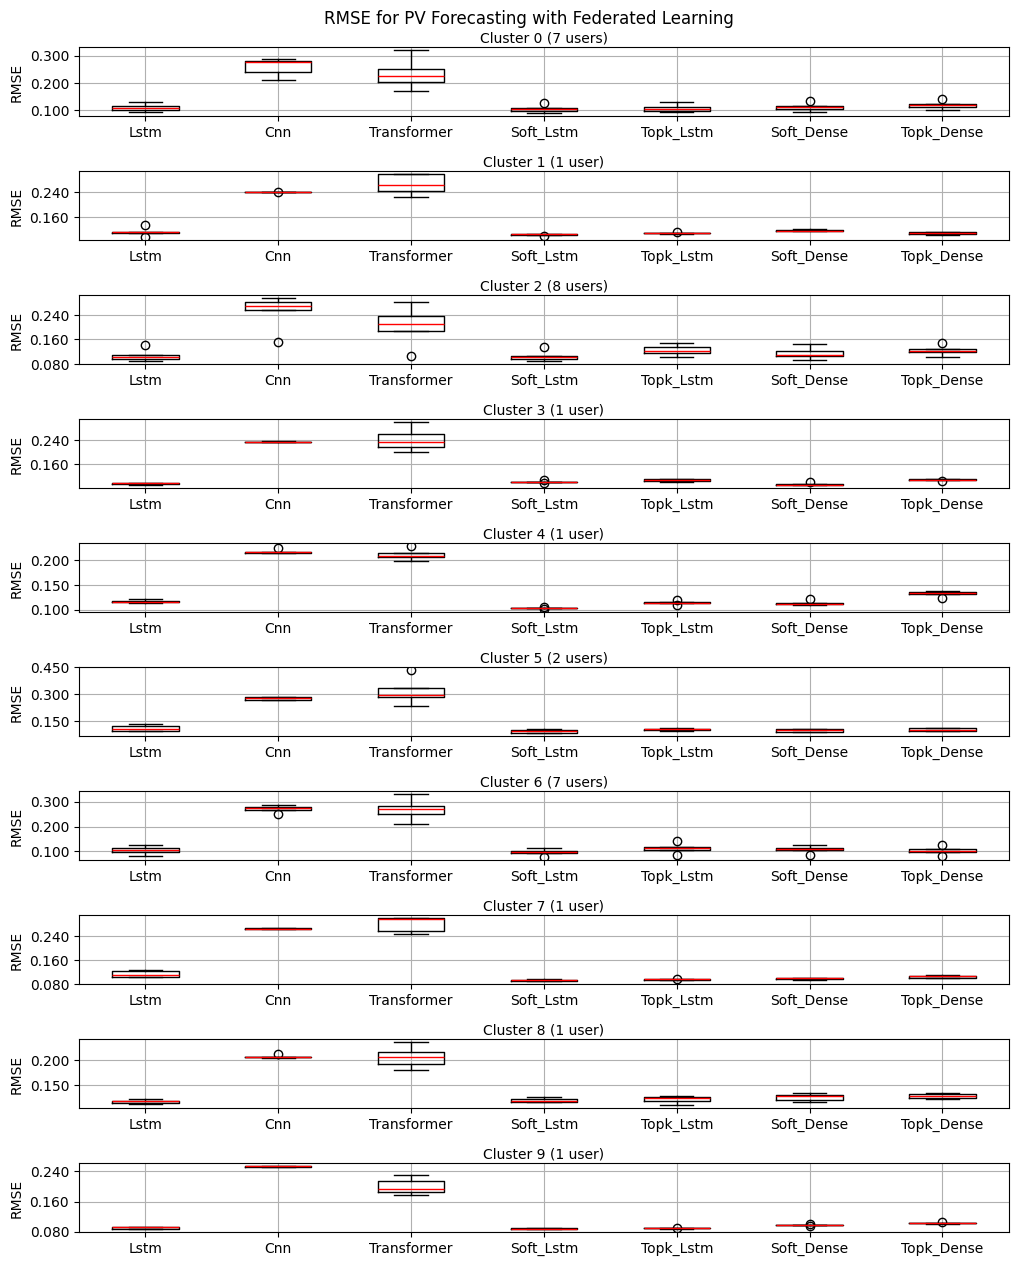

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


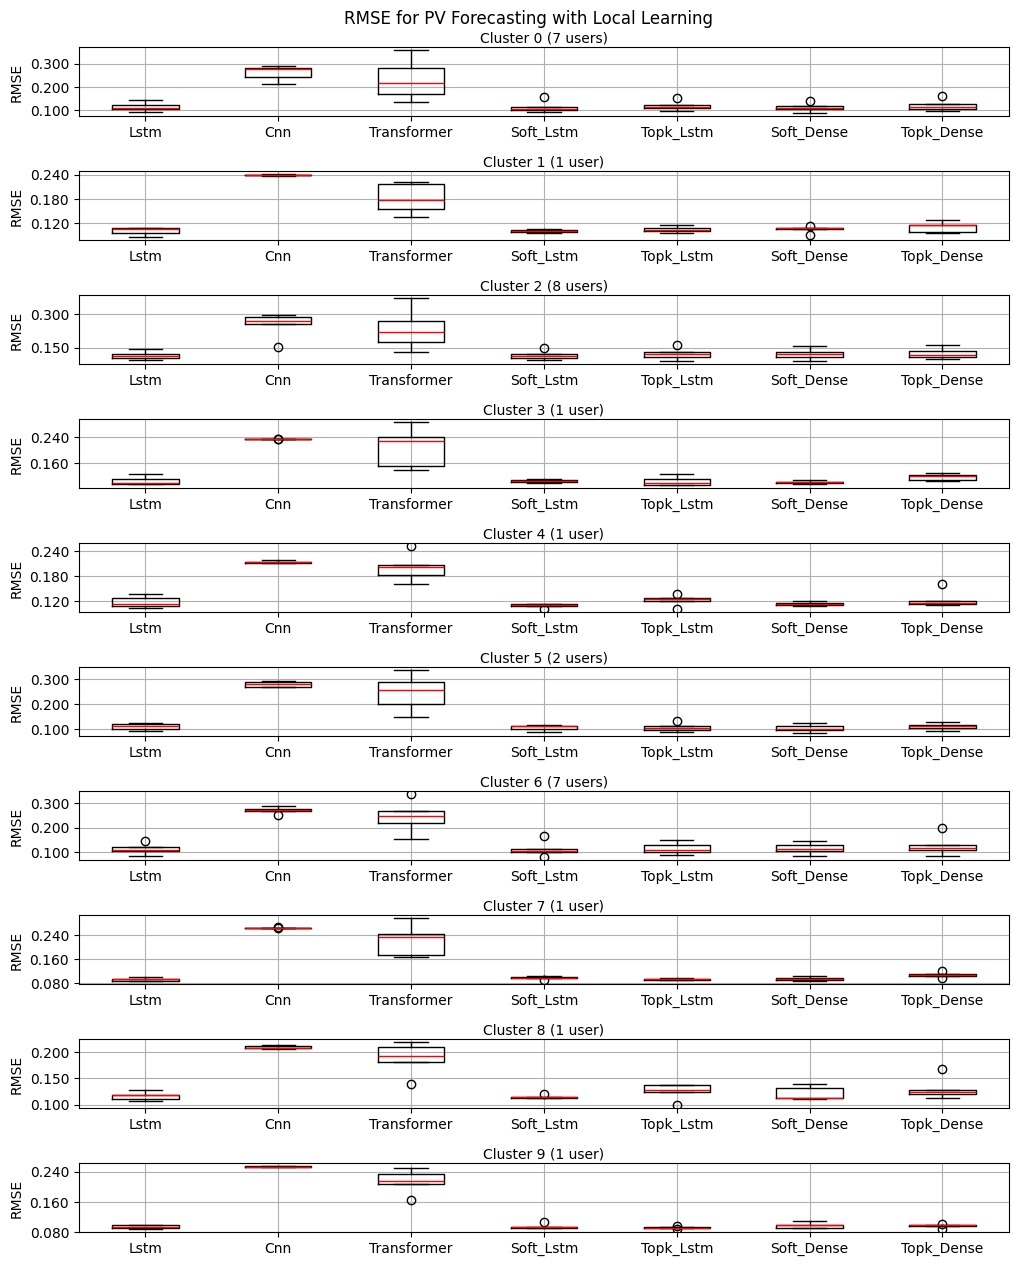

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


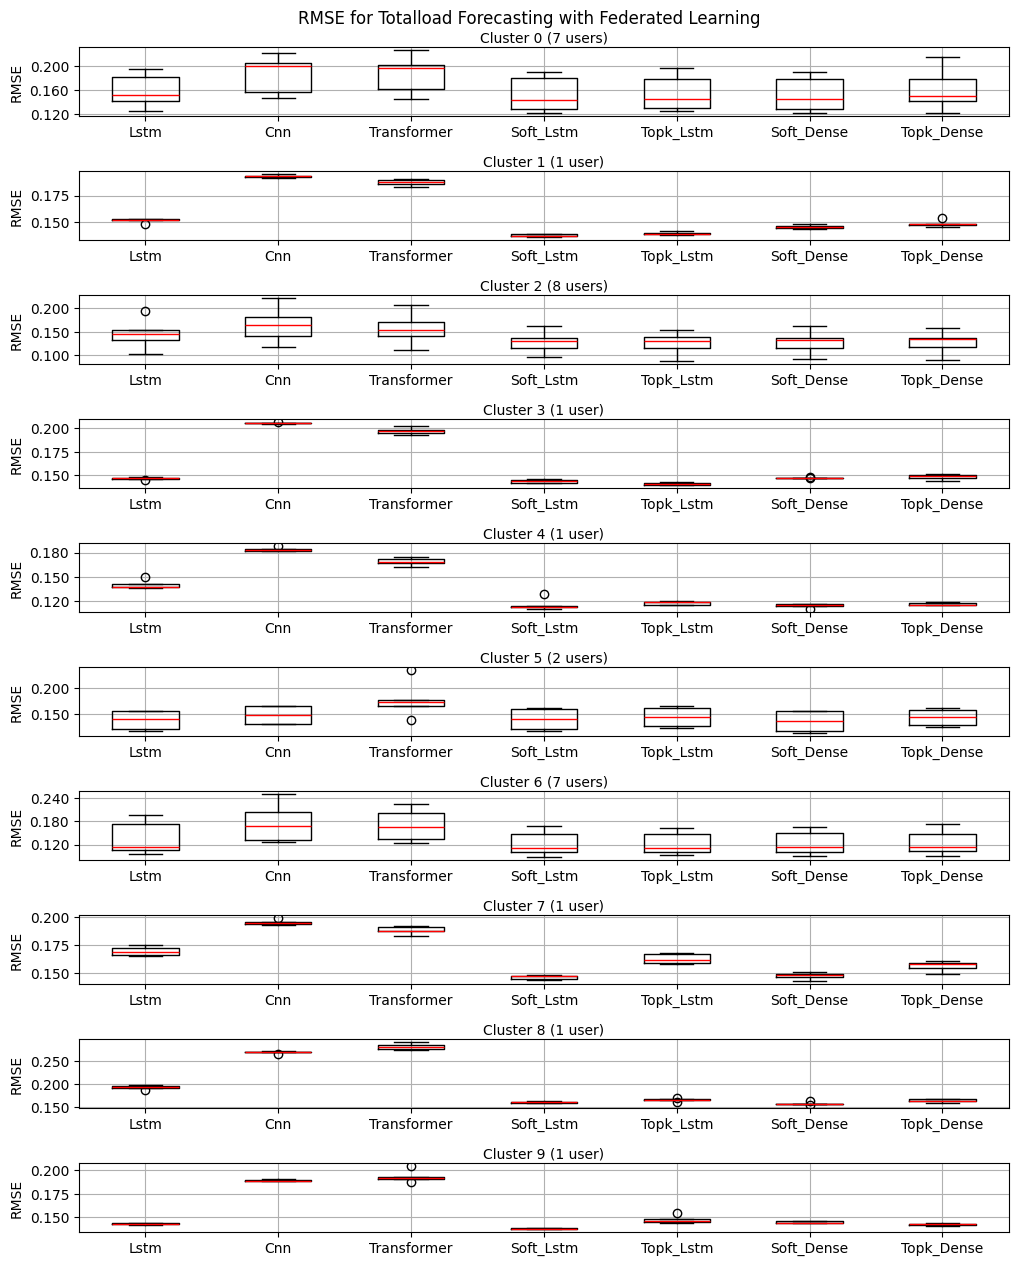

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\3404109889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


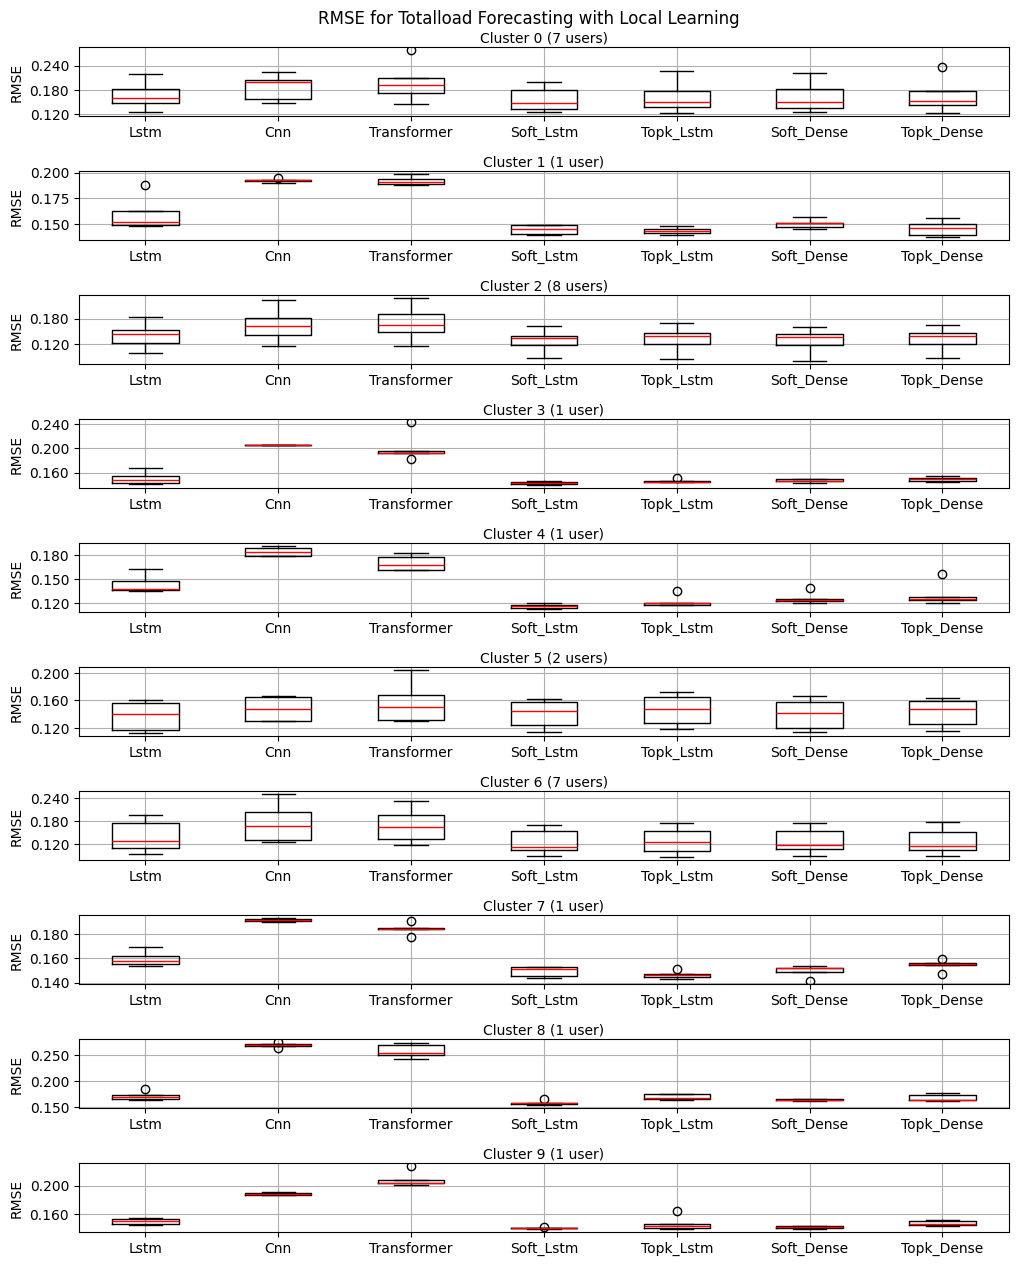

In [8]:

def get_plot_title(model_type, metric='RMSE'):
    """
    Returns a descriptive title based on the model type.
    """
    forecasting_type = model_type.split('_')[1]
    if 'FL' in model_type:
        return f'{metric} for {forecasting_type} Forecasting with Federated Learning'
    elif 'LL' in model_type:
        return f'{metric} for {forecasting_type} Forecasting with Local Learning'

def plot_rmse_boxplot(df, model_type, num_clusters, figsize=(12, 15)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrame, with each row representing a cluster.
    Adjusted to improve spacing and readability.
    """
    # Shorten model names by removing 'global_' prefix
    df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)

    plt.figure(figsize=figsize)
    for cluster_number in range(num_clusters):
        ax = plt.subplot(num_clusters, 1, cluster_number + 1)

        # Get the number of users in the current cluster
        num_users = len(cluster_users[cluster_number])
        
        # Filter data for the current cluster
        cluster_data = df[df['cluster'] == cluster_number]
        boxplot_data = cluster_data.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

        # Plot boxplot with black color
        boxplot_data.boxplot(ax=ax, notch=False, meanline=False, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, boxprops={'color': 'black'}, medianprops={'color': 'red'})
        
        # Set y-axis format
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
        
        #plt.xticks(rotation=25)
        plt.title(f'Cluster {cluster_number} ({num_users} {"user" if num_users == 1 else "users"})', y=0.95, fontsize=10)
        plt.ylabel('RMSE', fontsize=10)

    plt.suptitle(get_plot_title(model_type), fontsize=12, y=0.925)
    plt.subplots_adjust(hspace=0.8, top=0.9)  # Increase space between rows
    plt.show()

model_types = ['FL_Grossload', 'LL_Grossload', 'FL_Prosumption', 'LL_Prosumption', 'FL_PV', 'LL_PV', 'FL_Totalload', 'LL_Totalload']
num_clusters = 10  # Assuming 10 clusters

for model_type in model_types:
    df_model_type = combined_average_metrics[combined_average_metrics['model_type'].str.contains(model_type)]
    plot_rmse_boxplot(df_model_type, model_type, num_clusters)

# 2. Total results

In [9]:
# Load and process all DataFrames
all_results = []
for category, paths in file_paths.items():
    for path in paths:
        df = load_csv(path)
        processed_df = process_dataframe(df, scenario=category, metric='rmse')
        all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)

In [10]:
df.head(5)

user    architecture  train_time  avg_time_epoch       mse      rmse  \
0  user1  dense_topk_moe   19.192652        1.268889  0.022160  0.148863   
1  user1  dense_topk_moe   21.660702        1.264788  0.022770  0.150897   
2  user1  dense_topk_moe   16.666662        1.271509  0.023615  0.153672   
3  user1  dense_topk_moe   17.741851        1.258126  0.021033  0.145027   
4  user1  dense_topk_moe   18.923851        1.250994  0.021508  0.146656   

            mape       mae  
0  300166.687500  0.111269  
1  360673.156250  0.113948  
2  501497.500000  0.121942  
3  221556.703125  0.098156  
4  232475.328125  0.104041

In [11]:
#model_type = FL_Grossload, LL_Grossload, FL_Prosumption, LL_Prosumption, FL_PV, LL_PV, FL_Totalload, LL_Totalload
df_grossload = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Grossload")]
df_prosumption = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Prosumption")]
df_pv = combined_average_metrics[combined_average_metrics['model_type'].str.contains("PV")]
df_totalload = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Totalload")]

In [13]:
def get_plot_title_new(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


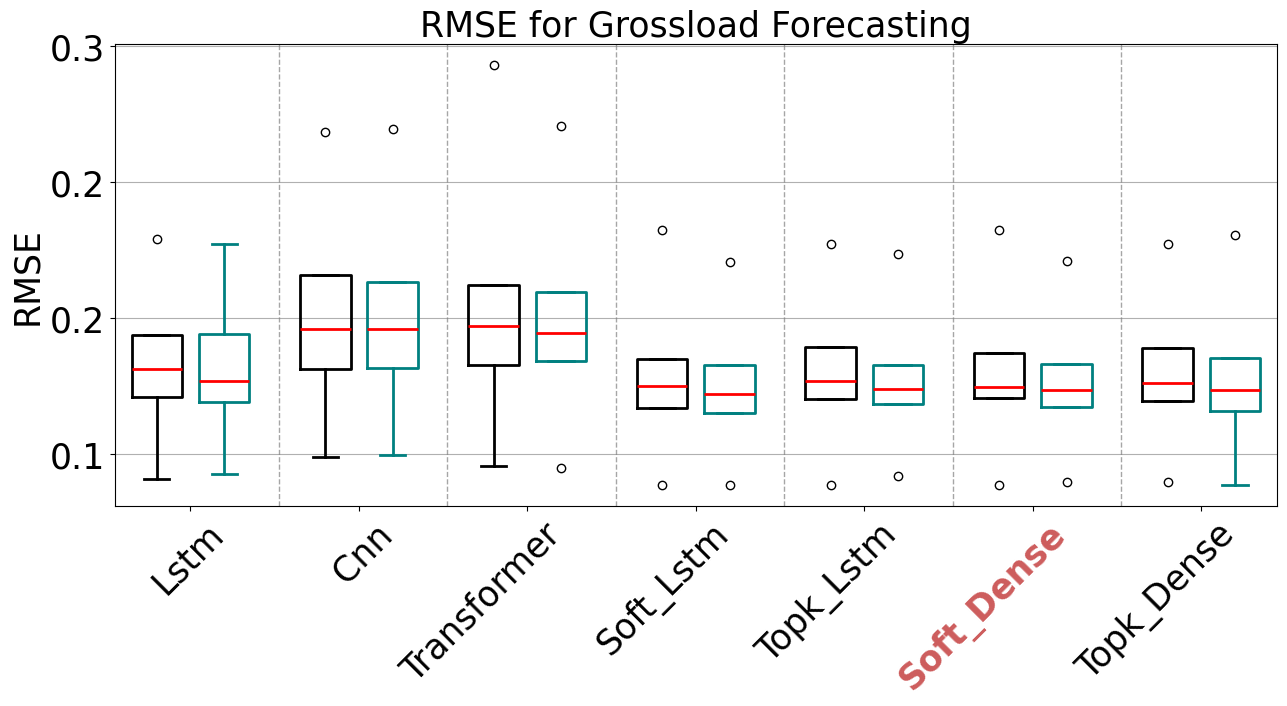

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


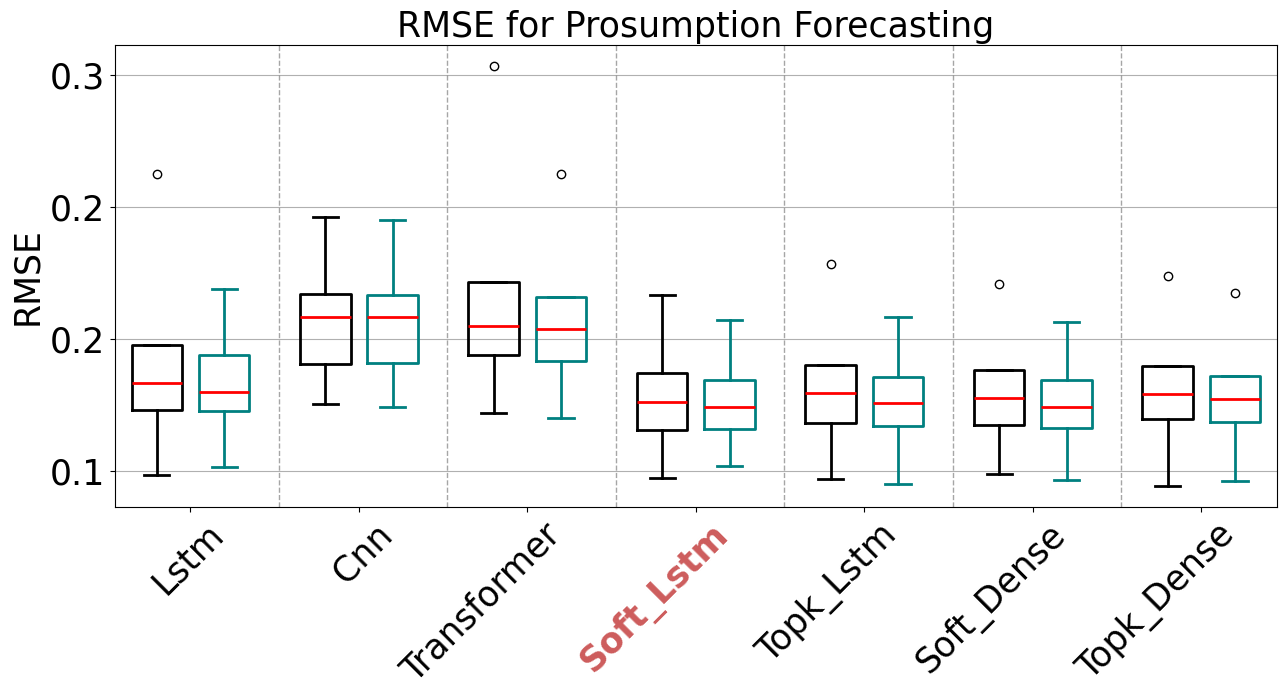

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


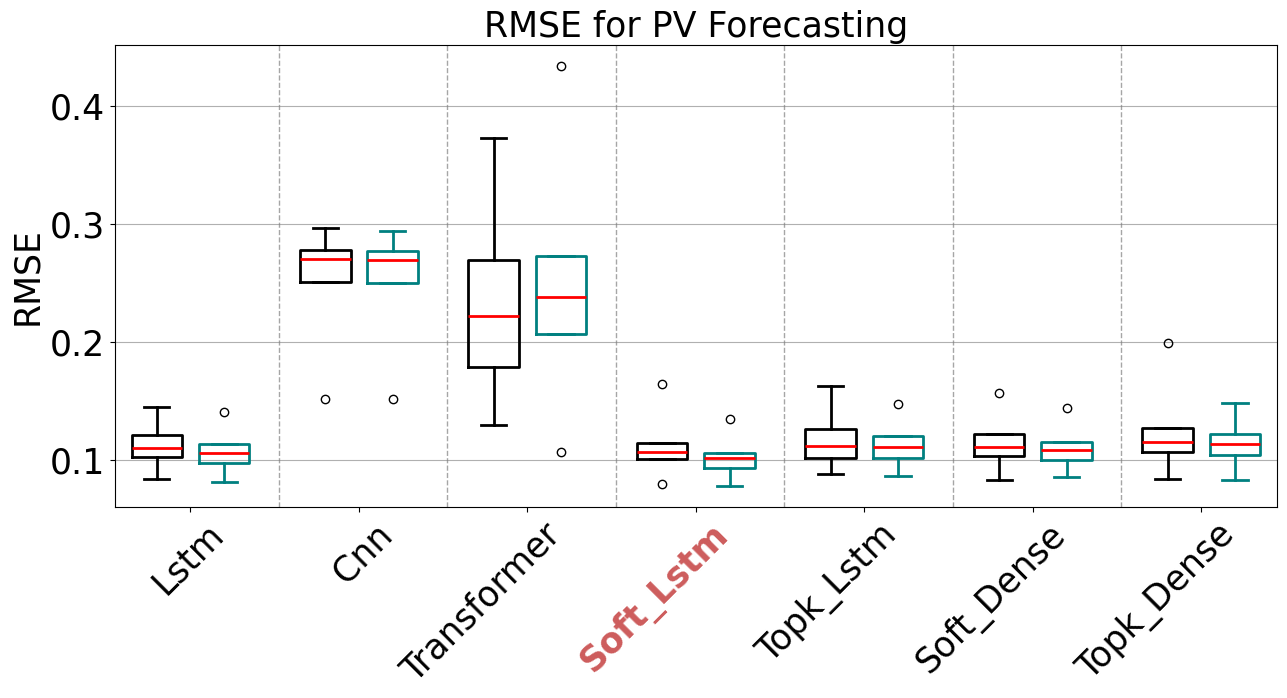

C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_13216\2143490308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


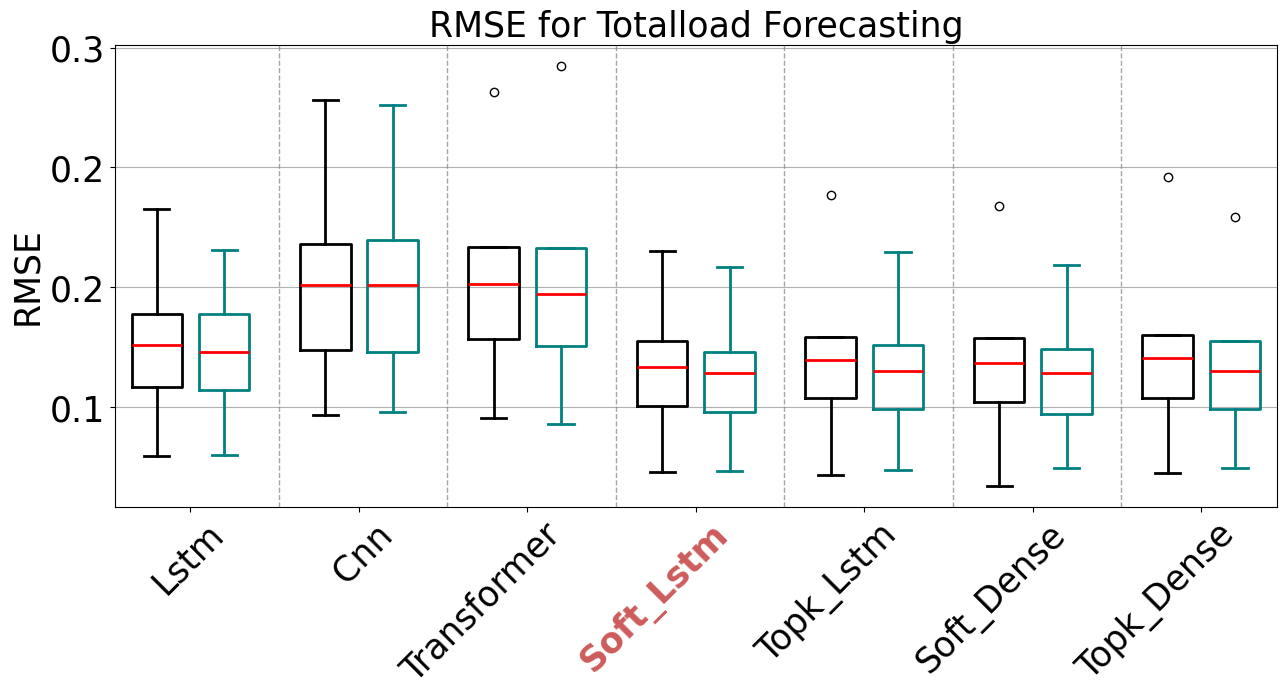

In [14]:
def plot_rmse_boxplot(df_ll, df_fl, title, figsize=(15, 6)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrames for LL and FL.
    """
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    # Prepare data for boxplot
    boxplot_data_ll = df_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
    boxplot_data_fl = df_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

    fontsize = 25
    # Plotting
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    
    # Plot Local Learning boxplots
    boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    # Plot Federated Learning boxplots in green
    boxplot_data_fl.boxplot(positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    plt.title(title, fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)
    #plt.ylim(0.050, 0.400)
    ax.tick_params(axis='y', labelsize=fontsize)
    
    x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
    x_labels = boxplot_data_ll.columns
    # Find the label with the lowest median
    lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
    for i, label in enumerate(x_labels):
        if label == lowest_median_label:
            ax.get_xticklabels()[i].set_color("indianred")
            ax.get_xticklabels()[i].set_weight("bold")
    
    # Define the offset value (adjust this as needed)
    offset = 0.4  # You can change this value to control the offset
    # Offset the x-label text to the left
    for label in ax.get_xticklabels():
        transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
        label.set_transform(transform)

    plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=fontsize)
    # Add horizontal lines as separation between labels
    for i in range(1, len(x_ticks)):
        plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    plt.gca().xaxis.grid(False)
    plt.show()

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in use_cases:
    df_ll = combined_average_metrics[combined_average_metrics['model_type'].str.contains('LL_' + use_case)]
    df_fl = combined_average_metrics[combined_average_metrics['model_type'].str.contains('FL_' + use_case)]
    title = get_plot_title_new(use_case)
    plot_rmse_boxplot(df_ll, df_fl, title)

C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


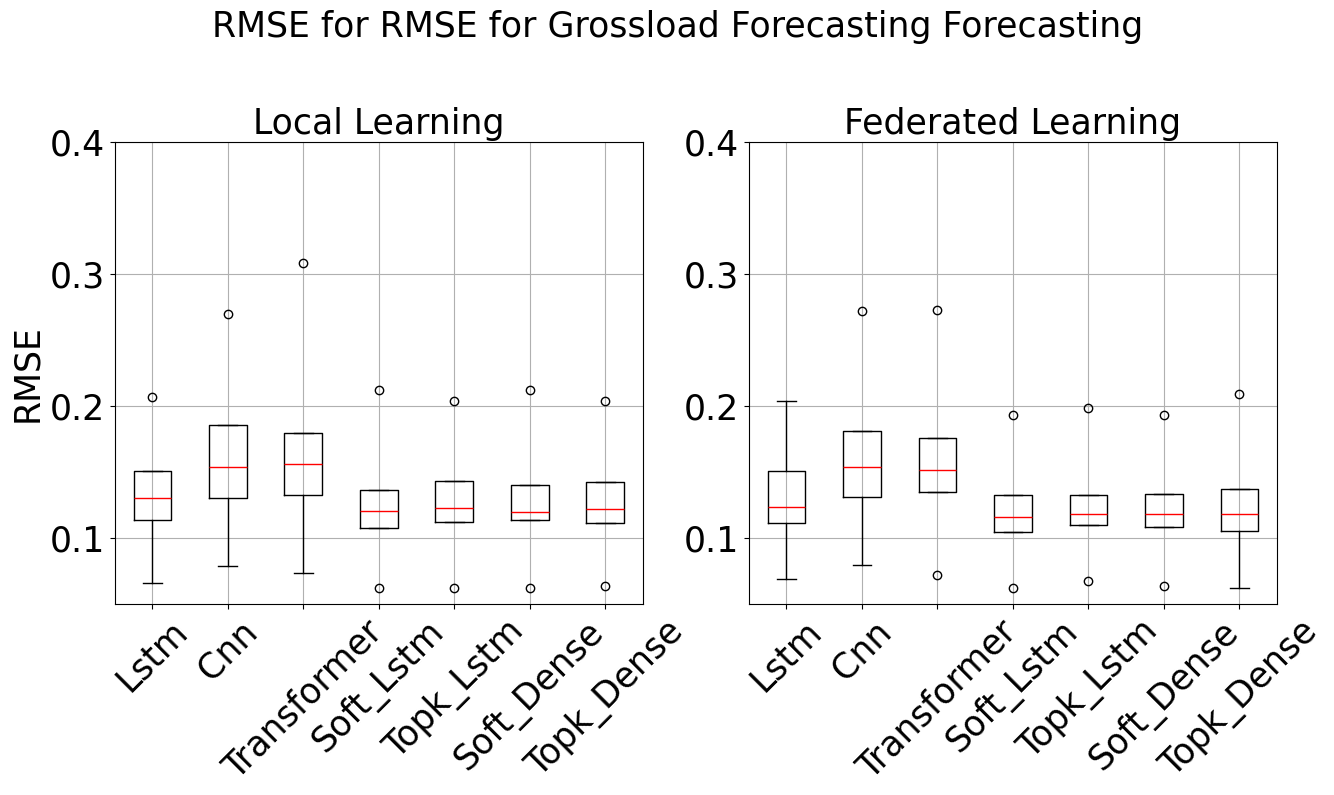

C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


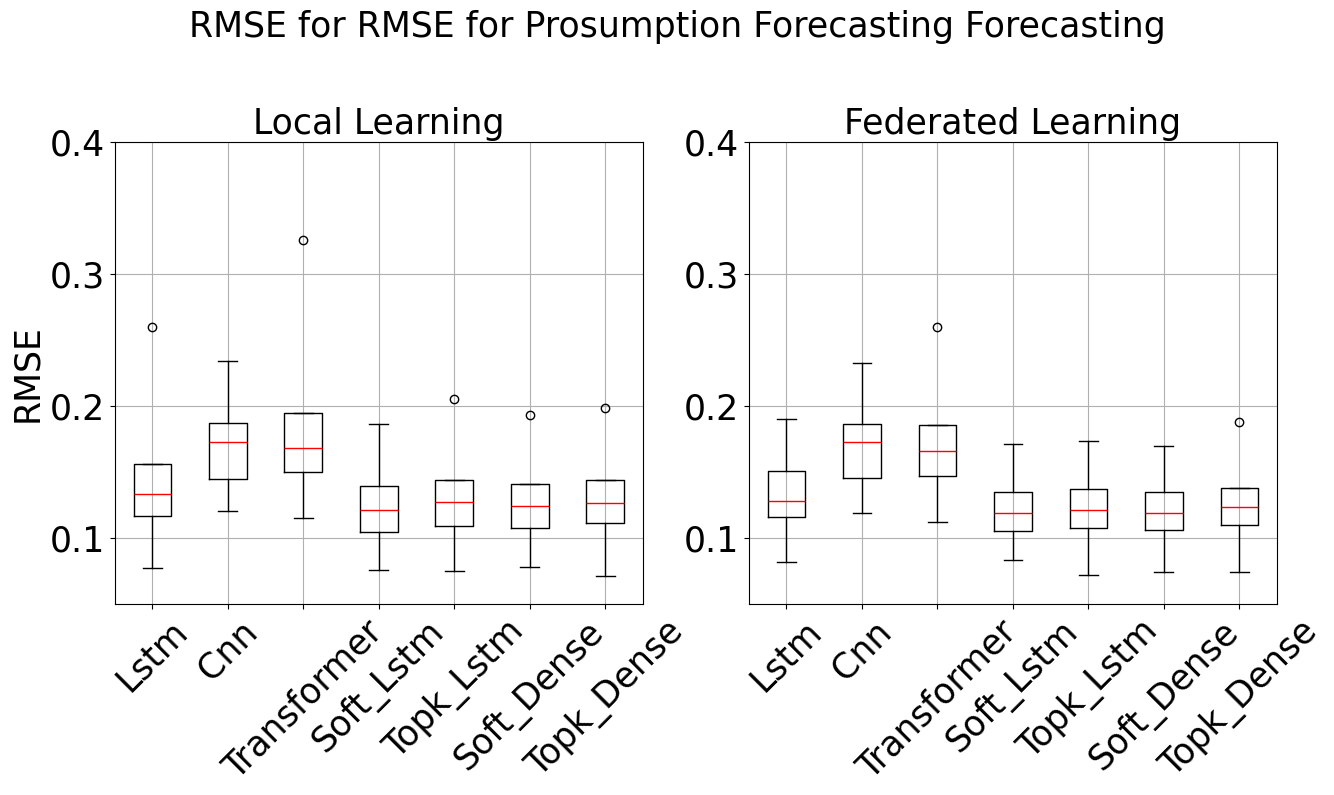

C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


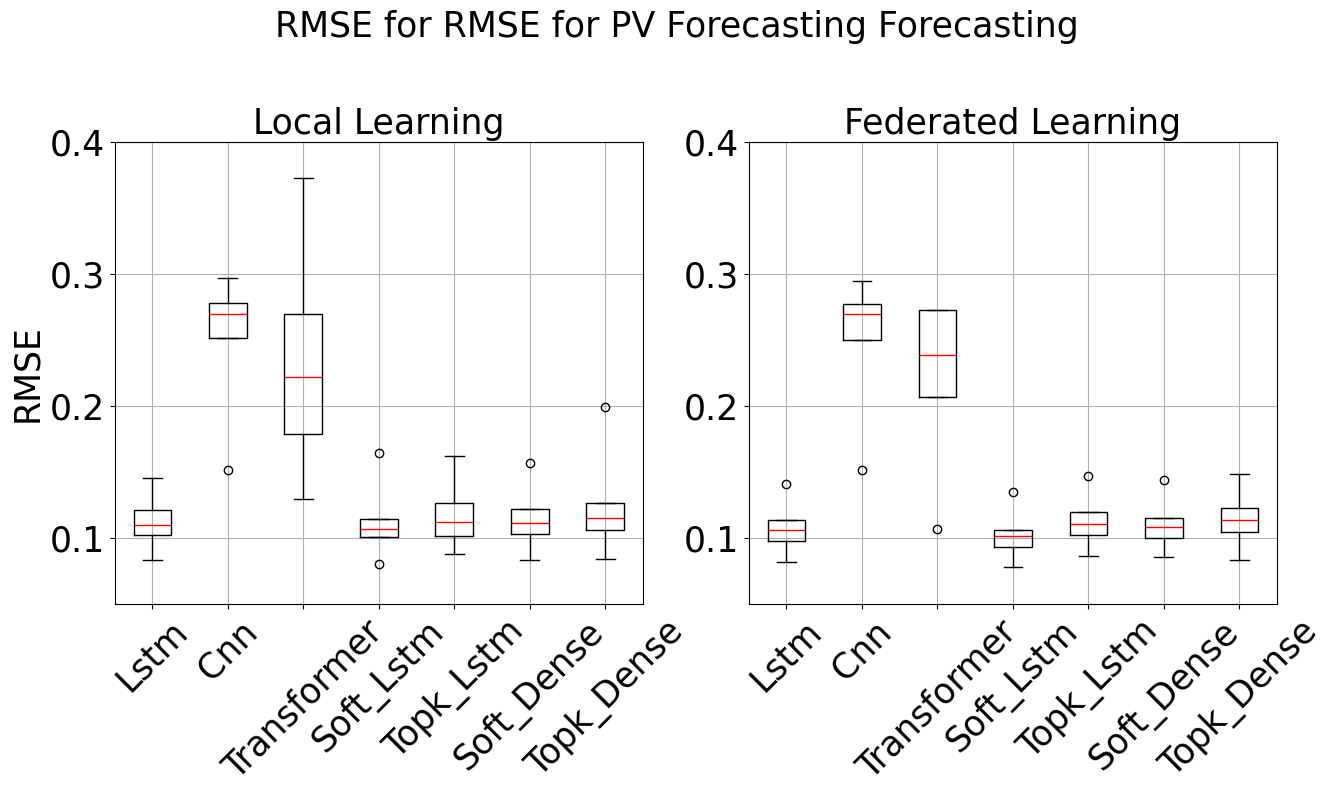

C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_26880\1394044814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


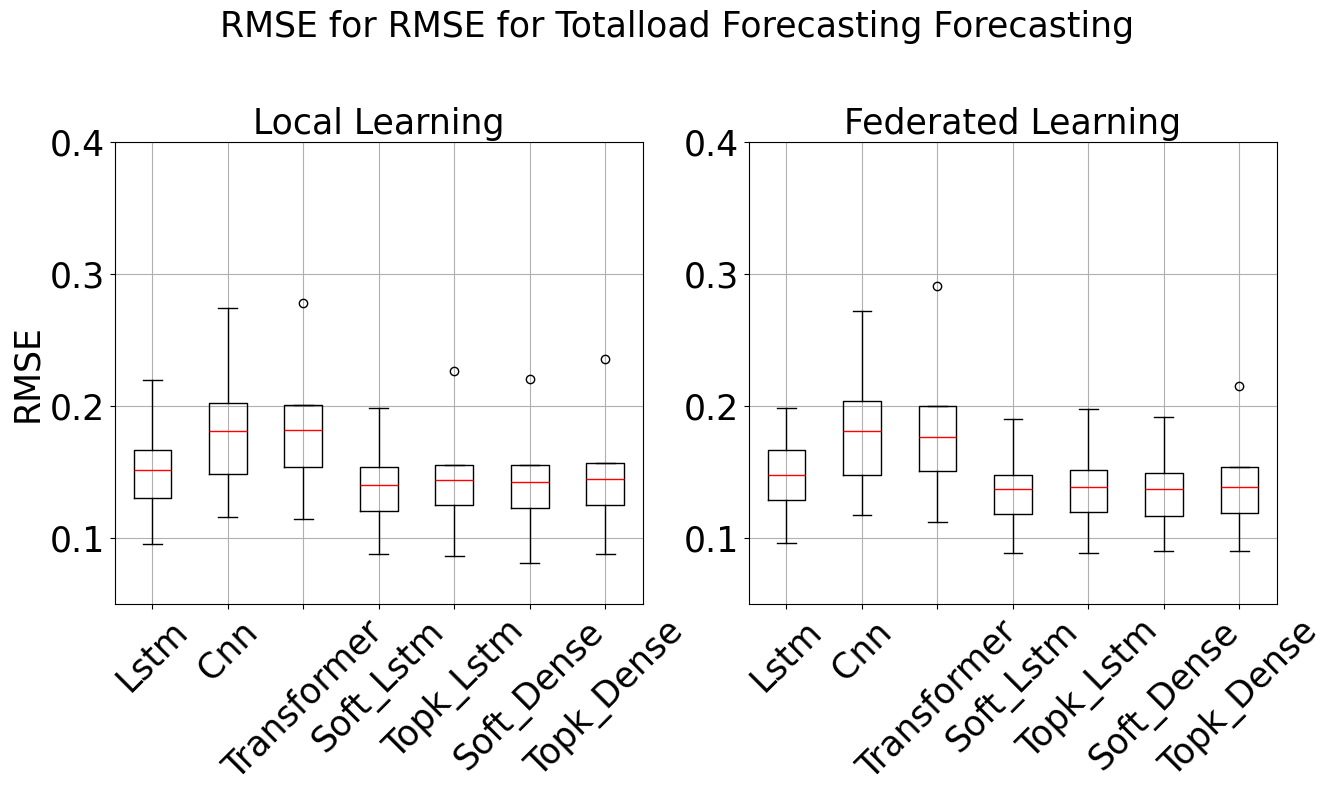

In [ ]:
def get_plot_title_new(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']


def plot_rmse_boxplot(df_ll, df_fl, title, figsize=(15, 6)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrames for LL and FL.
    """
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    # Prepare data for boxplot
    boxplot_data_ll = df_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
    boxplot_data_fl = df_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

    fontsize = 25
    # Plotting
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(121)
    boxplot_data_ll.boxplot(notch=False, meanline=False, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, boxprops={'color': 'black'}, medianprops={'color': 'red'})
    plt.title("Local Learning", fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)
    plt.ylim(0.050, 0.400)
    ax1.tick_params(axis='y', labelsize=fontsize)
    plt.xticks(rotation=45, fontsize=fontsize)

    ax2 = plt.subplot(122, sharey=ax1)
    boxplot_data_fl.boxplot(notch=False, meanline=False, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, boxprops={'color': 'black'}, medianprops={'color': 'red'})
    plt.title("Federated Learning", fontsize=fontsize)
    plt.ylim(0.050, 0.400) 
    plt.xticks(rotation=45, fontsize=fontsize)
    #ax2.set_facecolor('lightcyan')
    ax2.tick_params(axis='y', labelsize=fontsize)

    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    plt.subplots_adjust(wspace=0.2)
    plt.suptitle(f'RMSE for {title} Forecasting', fontsize=fontsize, y=1.1)
    plt.grid(True)
    plt.show()

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in use_cases:
    df_ll = combined_average_metrics[combined_average_metrics['model_type'].str.contains('LL_' + use_case)]
    df_fl = combined_average_metrics[combined_average_metrics['model_type'].str.contains('FL_' + use_case)]
    title = get_plot_title_new(use_case)
    plot_rmse_boxplot(df_ll, df_fl, title)

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


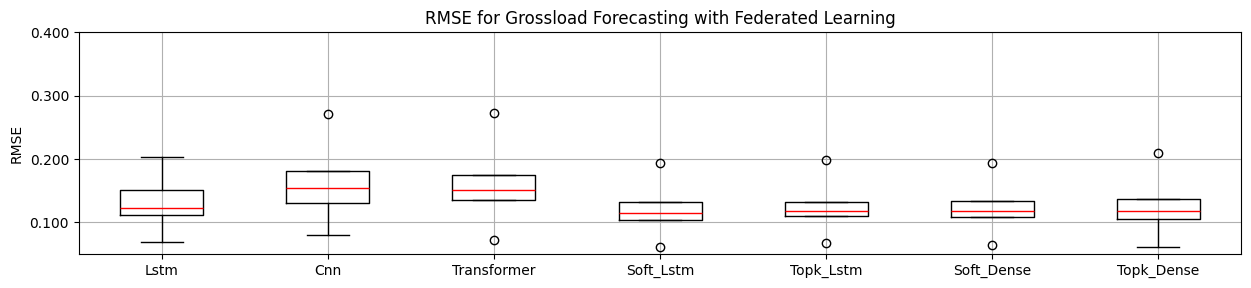

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


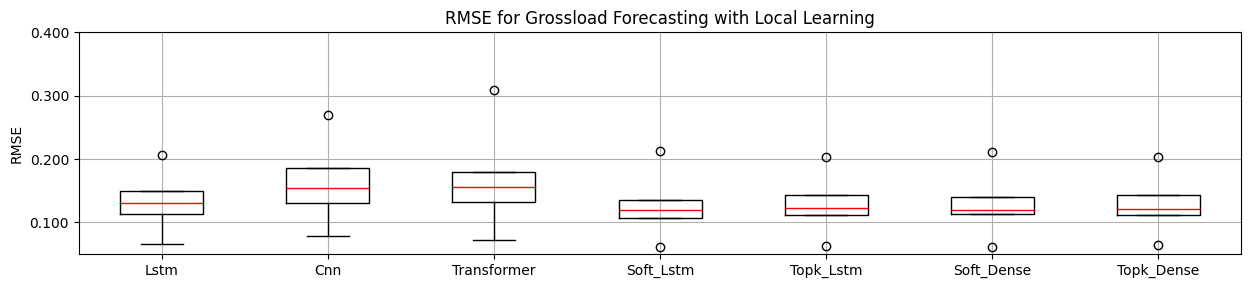

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


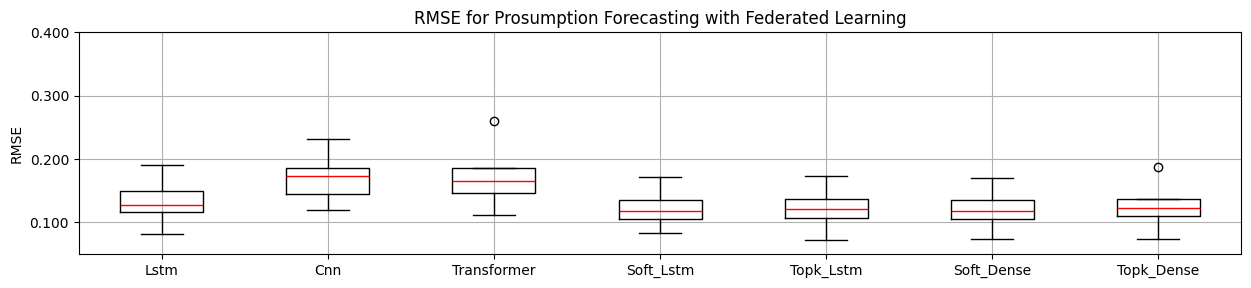

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


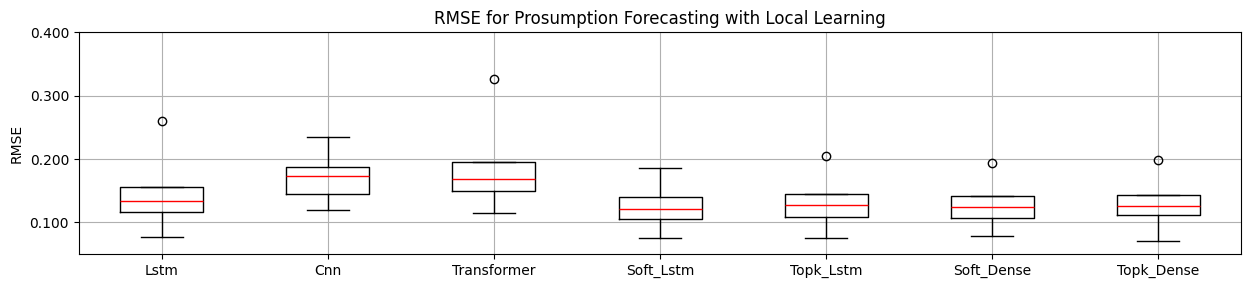

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


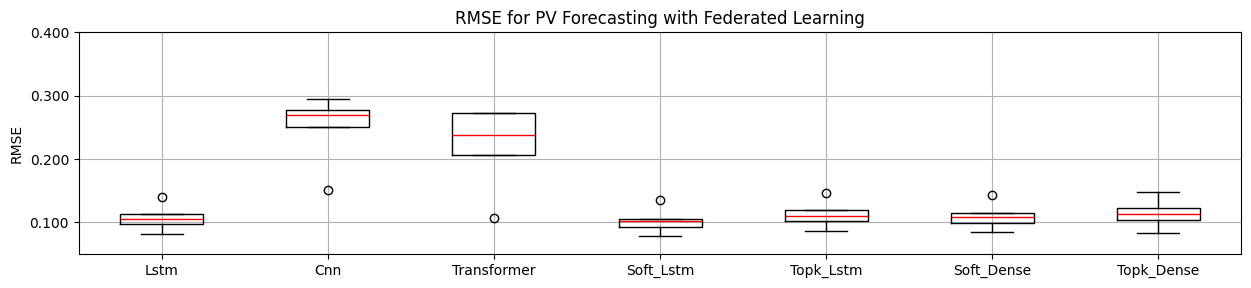

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


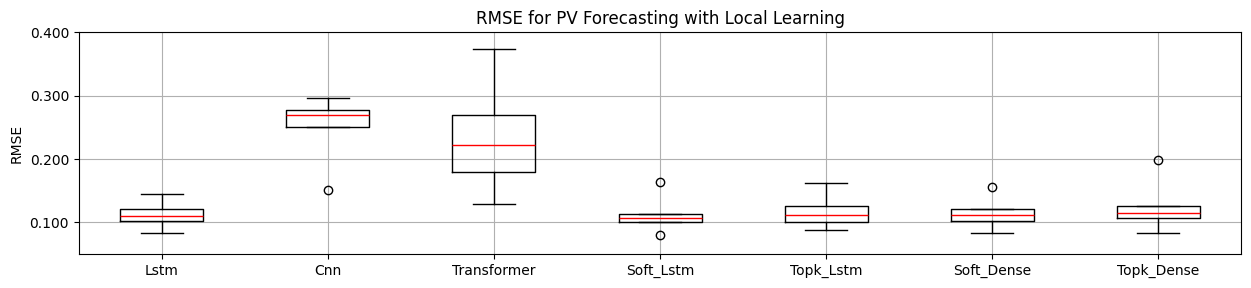

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


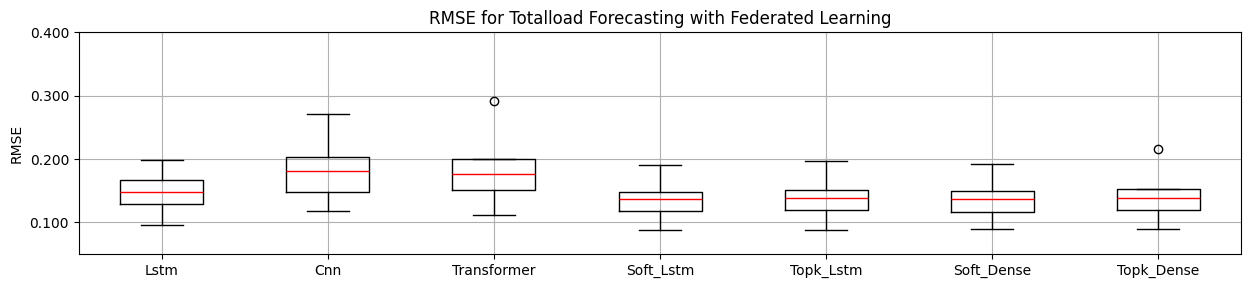

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14856\4152062301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)


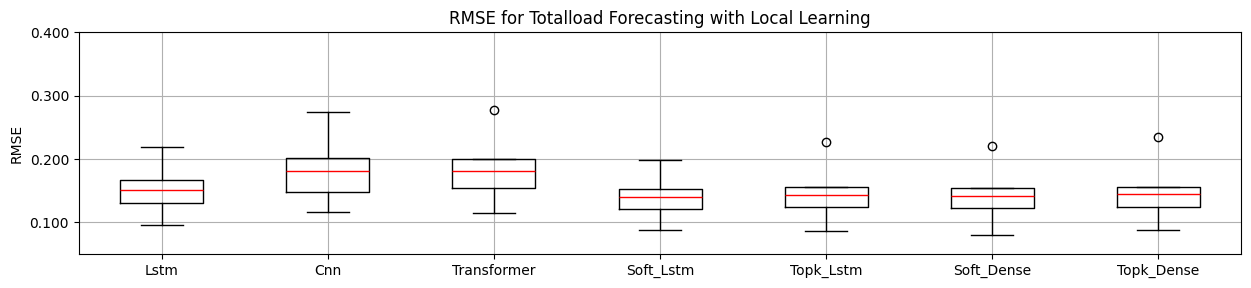

In [ ]:
def plot_rmse_boxplot(df, title, figsize=(15, 3)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrame.
    """
    df['architecture'] = df['architecture'].apply(standardize_and_simplify_model_names)

    boxplot_data = df.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
    plt.figure(figsize=figsize)
    ax = boxplot_data.boxplot(notch=False, meanline=False, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, boxprops={'color': 'black'}, medianprops={'color': 'red'})
    # Set y-axis format to have 3 digits after 0 and 4 ticks
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

    plt.ylim(0.050, 0.400) 
    plt.title(title, fontsize=12)
    plt.ylabel('RMSE', fontsize=10)
    plt.grid(True)
    plt.subplots_adjust(top=0.85)  # Adjust the title position
    plt.show()

# Model types
model_types = ['FL_Grossload', 'LL_Grossload', 'FL_Prosumption', 'LL_Prosumption', 'FL_PV', 'LL_PV', 'FL_Totalload', 'LL_Totalload']
num_clusters = 10  # Assuming 10 clusters

# Plotting boxplots for each model type
for model_type in model_types:
    df_model_type = combined_average_metrics[combined_average_metrics['model_type'].str.contains(model_type)]
    title = get_plot_title(model_type)
    plot_rmse_boxplot(df_model_type, title)